# Investigation of Distributed CNN Training Performances within the context of a Sea Turtle Face Classifier

## Introduction
The project goal is to distribute the training of a tensorflow CNN. The performance of the system will be heavily monitored along the whole pipeline. Dask is the framework of choice to distribute the tasks among a set of workers.  
https://www.dask.org/

The CNN will be provided with many photos that contain the face of a turtle and many photos that do not. The photos are labeled face or noface. The CNN must learn to distinguish between them. 

### Data / Pre-processing
The kaggle data set can be found at:  
https://www.kaggle.com/datasets/smaranjitghose/sea-turtle-face-detection  
The data set contains around 2000 images of sea turtles with their face clearly visable in the photo. Some examples are shown below.

The dataset is origionally intended for a face detection problem. Some pre-processing is required for it to suit our purpose. A csv file is provided that contains the position of boxes in the images that encloses the turtle faces. It also containes the file name of each image. This information is manipulated in a preamble() function to make face/noface image extractions easier.

The information from the preamble will be used to extract images that contain only the turtles face. Then it will be used to extract images that deffinetly do not contain a turtles face. The noface images contain a similar proportion of the origional image as the face images. This ensures the images are as similar as possible with the only difference being face or noface. 


In [1]:
#getting display images for the data description
from skimage import io, transform
from pathlib import Path
import numpy as np
import dask.dataframe as dd

onCV = True
def loadData():
    if onCV: labelsPath = Path('~/','daskShared_local','labels.csv')
    else: labelsPath = Path('/opt','workspace','data','labels.csv')
    df = dd.read_csv(labelsPath)
    df.columns = ['species', 'box_topleft_x', 'box_topleft_y', 'box_width', 'box_height', 'filename',       'image_width', 'image_height']
    meta = df.head(1)
    return df, meta
df, meta = loadData()
df = df.head(5)
allim = []
for i in range(len(df)):
    row = df.iloc[i]
    im = io.imread('/home/ubuntu/daskShared_local/images/'+row['filename'])
    im[row['box_topleft_y']:row['box_topleft_y']+row['box_height'],row['box_topleft_x']:row['box_topleft_x']+10,:] = 0
    im[row['box_topleft_y']:row['box_topleft_y']+10,row['box_topleft_x']:row['box_topleft_x']+row['box_width'],:] = 0
    im[row['box_topleft_y']:row['box_topleft_y']+row['box_height'],row['box_topleft_x']+row['box_width']:row['box_topleft_x']+row['box_width']+10,:] = 0
    im[row['box_topleft_y']+row['box_height']:row['box_topleft_y']+row['box_height']+10,row['box_topleft_x']:row['box_topleft_x']+row['box_width'],:] = 0
    #io.imsave('/home/ubuntu/displayim'+str(i)+'.jpeg',im)
    io.imshow(im)
    io.show()
# for i in range(len(allim)):
#     im = transform.resize(allim[i],(150*10,200*10,3))
#     print(np.shape(im))
#     if i == 0: 
#         img=im    
#     else:
#         img = np.concatenate((img,im), axis=1)
# io.imshow(img)
# io.show()

ImportError: Dask dataframe requirements are not installed.

Please either conda or pip install as follows:

  conda install dask                     # either conda install
  python -m pip install "dask[dataframe]" --upgrade  # or python -m pip install


### CNN, Implementations

In [321]:
#run this cell to release the ram that the workers are hoarding. 
# import ctypes
# def trim_memory() -> int:
#     libc = ctypes.CDLL("libc.so.6")
#     return libc.malloc_trim(0)

# client.run(trim_memory)

In [545]:
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import dask.array as da
from pathlib import Path
from dask.distributed import wait
from dask.distributed import Client
import pickle

from dask_image.imread import imread
from skimage import io, transform
import dask.array as da
import dask.delayed

from tensorflow.keras import models, layers
import tensorflow as tf

import pandas as pd

import re
import os

import time
import timeit

In [546]:
# are you on cloud veneto?
onCV = True

In [547]:
from dask.distributed import Client
if onCV:
    # must run to following command on this jupyter machine to set up cluster.  
    # dask-ssh 10.67.22.{178,193,212,246,25,52} --scheduler 10.67.22.233 --log-directory /home/ubuntu/daskShared_local/logs --ssh-username ubuntu --ssh-private-key /home/ubuntu/.ssh/dasktest
    client = Client('10.67.22.233:8786')
    print('Connecting to CV cluster')

else:
    #after doing docker-compose up the cluster is ready to connect
    client = Client('dask-scheduler:8786')
    print('Connecting to docker cluster')
    #dask-scheduler is an alias for the ip address of the scheduler. I believe it is set up in the image of the jupyter notebook machine. 

client

Connecting to CV cluster


<Client: 'tcp://10.67.22.233:8786' processes=6 threads=12, memory=23.04 GiB>

In [571]:
import paramiko

scheduler_ip = '10.67.22.233'
workers_ip = ['10.67.22.52','10.67.22.178','10.67.22.25','10.67.22.246','10.67.22.193','10.67.22.212']

def ssh_cmd(hostname, cmd_list):
    k = paramiko.RSAKey.from_private_key_file("/home/ubuntu/.ssh/dasktest")
    c = paramiko.SSHClient()
    c.load_host_keys(filename="/home/ubuntu/.ssh/known_hosts")
    c.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    c.connect(hostname = hostname, username = "ubuntu", pkey = k)
    for command in cmd_list:
        print ("Executing {}".format( command ))
        stdin , stdout, stderr = c.exec_command(command)
        print(stdout.read())
        print( "Errors")
        print(stderr.read())
        c.close()


#use this cell to run a cmd command on all the workers
# #set up worker
# # workers_ip = ['10.67.22.40','10.67.22.195']
mkdir = ['mkdir /home/ubuntu/daskShared_local/face']
sshfs = ["sudo sshfs -o allow_other,default_permissions,IdentityFile=/home/ubuntu/.ssh/dasktest,StrictHostKeyChecking=accept-new ubuntu@10.67.22.18:/home/ubuntu/daskShared_remote /home/ubuntu/daskShared_local"]
touch = ['touch /home/ubuntu/daskNotShared/progress/train.pr']
chmod = ['sudo chmod 666 /home/ubuntu/daskNotShared/daniel_logs/general.txt']
for worker in workers_ip:
    ssh_cmd(worker,mkdir)


Executing mkdir /home/ubuntu/daskShared_local/face
b''
Errors
b''
Executing mkdir /home/ubuntu/daskShared_local/face
b''
Errors
b'mkdir: cannot create directory \xe2\x80\x98/home/ubuntu/daskShared_local/face\xe2\x80\x99: File exists\n'
Executing mkdir /home/ubuntu/daskShared_local/face
b''
Errors
b'mkdir: cannot create directory \xe2\x80\x98/home/ubuntu/daskShared_local/face\xe2\x80\x99: File exists\n'
Executing mkdir /home/ubuntu/daskShared_local/face
b''
Errors
b'mkdir: cannot create directory \xe2\x80\x98/home/ubuntu/daskShared_local/face\xe2\x80\x99: File exists\n'
Executing mkdir /home/ubuntu/daskShared_local/face
b''
Errors
b'mkdir: cannot create directory \xe2\x80\x98/home/ubuntu/daskShared_local/face\xe2\x80\x99: File exists\n'
Executing mkdir /home/ubuntu/daskShared_local/face
b''
Errors
b'mkdir: cannot create directory \xe2\x80\x98/home/ubuntu/daskShared_local/face\xe2\x80\x99: File exists\n'


In [549]:
#run to check that the sheduler and workers have the same enviroments
#client.get_versions(check=True)

In [550]:
#run to delete everthing on the workers
client.restart()

<Client: 'tcp://10.67.22.233:8786' processes=6 threads=12, memory=23.04 GiB>

In [551]:
#run to see what is stored on each worker
#client.has_what()

In [552]:
client

<Client: 'tcp://10.67.22.233:8786' processes=6 threads=12, memory=23.04 GiB>

In [553]:
#set paths
path_lbl = Path('/opt','workspace','data','labels.csv')
if onCV: path_lbl = Path('/home','ubuntu','daskShared_local','labels.csv')

path_img = Path('/opt','workspace','data','images')
if onCV: path_img = Path('/home','ubuntu','daskShared_local','images')

#this file will be writted to all of the workers into this path.
#this path should not be in the folder that is shared between workers.
if onCV: path_weights = Path('/home','ubuntu','daskNotShared','weights.pkl')


# Preamble
In the preamble the labels.csv is loaded into a dask dataframe. Some basic operations are applied to get information that will be usefull later for the image pre processing. The data comefortably fits into ram and so dask automatically gives it one partition. 

First the task graph will be inspected for the entire preamble. Then the change in the task graph will be inspected as we change the number of partitions.

Then an analysis is performed for the time taken to perform the preamble as a function of the number of partitions. As the data comefortably fits into ram there is no risk of crashing the workers from too few larger partitions. It is expected that it will run the fasted with the number of partitions that equal the number of workers. This is because there is less time reading and writing. Similarly as the number of partitions grows beyond the number of workers it is expected the time taken will increase linearly. As then number of reads increases linearly.

In [554]:
def loadData():
    df = dd.read_csv(path_lbl)
    df.columns = ['species', 'box_topleft_x', 'box_topleft_y', 'box_width', 'box_height', 'filename',       'image_width', 'image_height']
    meta = df.head(1)
    return df, meta

df, meta = loadData()

def preamble(df, meta, persist=False):
    df = df.drop(columns='species')
    meta = meta.drop(columns = 'species')
    #adding bottom right box corners
    # co-ordinated measured from top left corner of image being 0
    df['box_bottomright_x'] = df['box_topleft_x'] + df['box_width']
    df['box_bottomright_y'] = df['box_topleft_y'] + df['box_height']
    meta['box_bottomright_x'] = 1
    meta['box_bottomright_y'] = 1
    
    # adding the max box dimension for best size analysis
    def maxdim(partition):
        partition['max_box_dim'] = np.maximum(partition['box_width'],partition['box_height'])
        return partition
    meta['max_box_dim'] = 1
    df = df.map_partitions(maxdim, meta = meta)
    
    # adding paths for easier file reading
    def makePath(partition):
        def makePath2(row):
            if onCV: return Path(path_img,row['filename'])
            
        partition['file_path'] = partition.apply(makePath2, axis = 1)
        return partition
    meta['file_path'] = Path()
    df = df.map_partitions(makePath, meta = meta)
    
    # add a face number (taken fromt he file name) to save the files properly
    def faceNumber(partition):
        def faceNumber2(row):
            filename = row['filename']
            found = re.search('[0-9]+',filename)
            return filename[found.start():found.end()]
        
        partition['face_number'] = partition.apply(faceNumber2, axis = 1)
        return partition
    meta['face_number'] = 'a String'
    df = df.map_partitions(faceNumber, meta = meta)

    # getting rid of images with extra faces
    df = df.groupby('filename', sort = False).first()
    meta = meta.drop(columns='filename')
    df = df.reset_index()
    df = df.drop(columns='filename')
    df = df.reset_index().set_index('index')
    if persist==True: df = df.persist()
    
    return df, meta

predf, premeta = preamble(df, meta)
#predf.visualize()
del predf, premeta

In [576]:
%%time
from skimage import util
def getFace(partition):
    def getFace2(image_info):
        im = io.imread(image_info['file_path'])
        im = im[:,:,:3]# remove fourth channel if it exists
        y = image_info['box_topleft_y']
        x = image_info['box_topleft_x']
        dim = {'box_width':image_info['box_width'],'box_height':image_info['box_height']}
        max_dim_key = max(dim, key = dim.get)
        max_dim = image_info['max_box_dim']
        dif = np.abs(image_info['box_width'] - image_info['box_height'])
        half_dif = int(dif/2)
        if max_dim_key == 'box_width':
            new_top = y-half_dif
            new_bottom = new_top + max_dim
            pad_width = 0
            if(new_top < 0):
                pad_width = -new_top
                new_top = 0
            if(new_bottom > image_info['image_height']):
                pad_width = new_bottom - image_info['image_height']
                new_bottom = image_info['image_height']
            
            im = np.pad(im, pad_width = [(pad_width,pad_width),(pad_width,pad_width),(0,0)], mode = 'reflect')
            face = im[ new_top : new_bottom, x : x+max_dim, :]
            del new_top, new_bottom, pad_width
            
        if max_dim_key == 'box_height':
            new_left = x-half_dif
            new_right = new_left + max_dim
            pad_width = 0
            if(new_left < 0):
                pad_width = -new_left
                new_left = 0
            if(new_left > image_info['image_width']):
                pad_width = new_left - image_info['image_width']
                new_left = image_info['image_width']
            im = np.pad(im, pad_width = [(pad_width,pad_width),(pad_width,pad_width),(0,0)], mode = 'reflect')
            face = im[ y : y+max_dim, new_left : new_right, :]
            del new_left, new_right, pad_width
        face = transform.resize(face,(198,198,3))
        face = util.img_as_ubyte(face)
        del im, y, x, dim, max_dim_key, max_dim, dif, half_dif
        if onCV: path = Path('/home','ubuntu','daskShared_local','face','face_'+image_info['face_number']+'.jpg')

        else :path = Path('/opt','workspace','data','Faces3','face_'+image_info['face_number']+'.jpg')
        io.imsave(path,face)
        return [face]
    partition['face_img'] = partition.apply(getFace2, axis = 1)
    return partition

# df, meta = loadData()
# df, meta = preamble(df, meta, persist=True)
# df = df.repartition(npartitions=1000)
# meta['face_img'] = [np.zeros((198,198,3))]
# facedf = df.map_partitions(getFace, meta = meta).persist()
# del df
# facedf

CPU times: user 217 ms, sys: 8.28 ms, total: 225 ms
Wall time: 649 ms


,box_topleft_x,box_topleft_y,box_width,box_height,image_width,image_height,box_bottomright_x,box_bottomright_y,max_box_dim,file_path,face_number,face_img
npartitions=1000,,,,,,,,,,,,
0,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object,object
1,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
1996,...,...,...,...,...,...,...,...,...,...,...,...
1998,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
fs = nofacedf.head(3)['face_img']
for img in fs:
    io.imshow(img)
    io.show()

## Training memory summary
many unmanaged memory warnings appear. 
after 2 training runs trim took about 0.5GB of ram off of each worker
all the dels in and before training have saved about 0.5GB of ram per worker. 


In [577]:
def getNoFace(partition):
    def getNoFace2(image_info):
        im = io.imread(image_info['file_path'])
        im = im[:,:,:3]# remove fourth channel if it exists
        im_left = im[:, 0:image_info['box_topleft_x'] ,:]
        im_right = im[:, image_info['box_bottomright_x']: ,:]
        im_top = im[0:image_info['box_topleft_y'],:,:]
        im_bottom = im[image_info['box_bottomright_y']:,:,:]
        del im
        var = locals()
        sizes ={'im_left':np.min(np.shape(im_left)[0:2]),'im_right':np.min(np.shape(im_right)[0:2]),'im_top':np.min(np.shape(im_top)[0:2]),'im_bottom':np.min(np.shape(im_bottom)[0:2])}
        max_side_key = max(sizes, key = sizes.get)
        rand_gen = np.random.default_rng(12345)
        max_box_dim = np.max([image_info['box_width'],image_info['box_height']])
        if sizes[max_side_key]<max_box_dim:
            side = var[max_side_key]
            dim = np.shape(side)[0:2]
            side_max_ind = np.argmax(dim)
            side_min_ind = not side_max_ind
            high = dim[side_max_ind] - dim[side_min_ind]
            along = rand_gen.integers(low = 0, high = high)
            if(side_max_ind == 0):
                noface = side[along:along+dim[side_min_ind],:,:]
            elif(side_max_ind == 1):
                noface= side[:, along:along+dim[side_min_ind] ,:]
            del side, dim, side_max_ind, side_min_ind, high, along
        else:
            side = var[max_side_key]
            side_width = np.shape(side)[1]
            side_height = np.shape(side)[0]
            rtlx = rand_gen.integers(low = 0, high = side_width - max_box_dim)
            rtly = rand_gen.integers(low = 0, high = side_height - max_box_dim)
            noface = side[rtly:rtly+max_box_dim, rtlx:rtlx+max_box_dim, :]
            del side, side_width, side_height, rtlx, rtly
        del var, sizes, max_side_key, rand_gen, max_box_dim
        noface = transform.resize(noface,(198,198,3)) 
        if onCV: path = Path('/home/ubuntu/daskShared_local/noface/noface_'+image_info['face_number']+'.jpg')
        else: path = Path('/opt','workspace','data','noFaces3','noFace_'+image_info['face_number']+'.jpg')
        io.imsave(path,noface)
        return [noface]
    partition['noface_img'] = partition.apply(getNoFace2, axis = 1)
    return partition

# df, meta = loadData()
# df, meta = preamble(df,meta)
# df = df.repartition(npartitions=1000)
# meta['noface_img'] = [np.zeros((198,198,3))]
# nofacedf = df.map_partitions(getNoFace, meta = meta).persist()
# del df
# nofacedf

,box_topleft_x,box_topleft_y,box_width,box_height,image_width,image_height,box_bottomright_x,box_bottomright_y,max_box_dim,file_path,face_number,noface_img
npartitions=1000,,,,,,,,,,,,
0,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object,object
1,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
1996,...,...,...,...,...,...,...,...,...,...,...,...
1998,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
nfs = nofacedf.head(3)['noface_img']
for img in nfs:
    io.imshow(img)
    io.show()

In [499]:
drop = ['box_topleft_x','box_topleft_y','box_width','box_height','image_width','image_height','box_bottomright_x','box_bottomright_y','max_box_dim','file_path']
data = nofacedf.drop(columns=drop)
data['face_img'] = facedf['face_img']
data.persist()

,face_number,noface_img,face_img
npartitions=1000,,,
0,object,object,object
1,...,...,...
...,...,...,...
1996,...,...,...
1998,...,...,...


In [557]:
#make the data dataframe that contains only information relivalant to cnn
def getData():
    df, meta = loadData()
    df, meta = preamble(df, meta)
    df = df.repartition(npartitions=1000)
    meta['face_img'] = [np.zeros((198,198,3))]
    facedf = df.map_partitions(getFace, meta = meta)
    del df  

    df, meta = loadData()
    df, meta = preamble(df,meta)
    df = df.repartition(npartitions=1000)
    meta['noface_img'] = [np.zeros((198,198,3))]
    nofacedf = df.map_partitions(getNoFace, meta = meta)
    del df  
    drop = ['box_topleft_x','box_topleft_y','box_width','box_height','image_width','image_height','box_bottomright_x','box_bottomright_y','max_box_dim','file_path']
    data = nofacedf.drop(columns=drop)
    data['face_img'] = facedf['face_img']
    del nofacedf
    del facedf
    return data

In [ ]:
#make the g6.py file with everything the workers need
#remove old file
try: client.run(lambda dask_worker: os.remove(os.path.join(dask_worker.local_directory, "g6.py")))
except: print("No g6.py file was on the workers, adding it now")
#the code below is displayed as such for syntax highlighting. It is then made into a string and written to a file to be sent to the workers and used as a g6 package
from tensorflow.keras import models, layers
import tensorflow as tf
import pickle
def build_cnn():
    cnn = models.Sequential([
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        #dense
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    # compile
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #summary
    #print(cnn.summary())
    return cnn

cnn = build_cnn()
#make a pickle file on the worker with the initial weights
def weights_init():
    weights = cnn.get_weights()
    f_weights = open(path_weights, 'wb')
    pickle.dump(weights, f_weights)                     
    f_weights.close()
    
# once the weights have been trained. This brings them from the workers to this machine for validation
def weights_get():
    f_weights = open(path_weights,'rb')
    weights = pickle.load(f_weights)
    f_weights.close()
    return weights
#weights = list(client.run(weights_get).values())

#now we have the best weights we need to write them to each worker so they can re-train from the best weights
def weights_set_best(weights_best):
    f_weights = open(path_weights,'wb')
    pickle.dump(weights_best,f_weights)
    f_weights.close()
    del f_weights, weights_best


contents = "\
from tensorflow.keras import models, layers\n\
import tensorflow as tf\n\
import pickle\n\
def build_cnn():\n\
    cnn = models.Sequential([\n\
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),\n\
        layers.MaxPooling2D((10,10)),\n\
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),\n\
        layers.MaxPooling2D((10,10)),\n\
        #dense\n\
        layers.Flatten(),\n\
        layers.Dense(50, activation='relu'),\n\
        layers.Dense(2, activation='softmax')\n\
    ])\n\
    # compile\n\
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])\n\
    #summary\n\
    #print(cnn.summary())\n\
    return cnn\n\
\n\
cnn = build_cnn()\n\
#make a pickle file on the worker with the initial weights\n\
def weights_init():\n\
    weights = cnn.get_weights()\n\
    f_weights = open('/home/ubuntu/daskNotShared/weights.pkl', 'wb')\n\
    pickle.dump(weights, f_weights)\n\
    f_weights.close()\n\
    \n\
# once the weights have been trained. This brings them from the workers to this machine for validation\n\
def weights_get():\n\
    f_weights = open('/home/ubuntu/daskNotShared/weights.pkl','rb')\n\
    weights = pickle.load(f_weights)\n\
    f_weights.close()\n\
    return weights\n\
#now we have the best weights we need to write them to each worker so they can re-train from the best weights\n\
def weights_set_best(weights_best):\n\
    f_weights = open('/home/ubuntu/daskNotShared/weights.pkl','wb')\n\
    pickle.dump(weights_best,f_weights)\n\
    f_weights.close()\n\
    del f_weights, weights_best"

f_py = open("g6.py",'w')
f_py.write(contents)
f_py.close()

client.upload_file('g6.py')
#use to remove unwanted files that have been uploaded
#client.run(lambda dask_worker: os.remove(os.path.join(dask_worker.local_directory, "file.py")))

In [565]:
#define the function that will train on each partition. It will load weights, train, then write the improved weights over the same file
@dask.delayed
def train(partition,monitor=False):
    if monitor:
        def log(log="",clear=False):
            f_log = open("/home/ubuntu/daskNotShared/daniel_logs/general.txt",'a')
            f_log.write(log+'\n')
            f_log.close()

        f_progress = open("/home/ubuntu/daskNotShared/progress/train.pr",'a')
        f_progress.write('1 ')
        f_progress.close()

        log('making partition data cnn ready')
        
    #convert the dataframe to a form that will go into the cnn
    faces = np.array([i[0] for i in partition['face_img'].values])
    labelsF = np.ones(np.shape(faces)[0])    
    nofaces = np.array([i[0] for i in partition['noface_img'].values])
    labelsNF = np.zeros(np.shape(nofaces)[0])
    data = tf.convert_to_tensor(np.concatenate((faces,nofaces), axis = 0))
    labels = tf.convert_to_tensor(np.concatenate((labelsF,labelsNF)))
    del faces, labelsF, nofaces, labelsNF
    #---------------------------------------------------
    if monitor: log('getting weights from file')
    #get init/best weights from pickle file 
    f_weights = open("/home/ubuntu/daskNotShared/weights.pkl",'rb')
    weights = pickle.load(f_weights)
    f_weights.close()
    del f_weights
    if monitor: log('training on partition data')
    cnn = g6.cnn
    cnn.set_weights(weights)
    fit = cnn.fit(data,labels, epochs = 10)
    if monitor: log('getting and saving weights\n---------------------------------------\n\n')
    weights = cnn.get_weights()
    f_weights = open('/home/ubuntu/daskNotShared/weights.pkl', 'wb')
    pickle.dump(weights, f_weights)                     
    f_weights.close()
    del f_weights, weights, fit, data, labels, cnn
    
    #return pd.DataFrame({"nothing":[None]})

def train_run(data_tr):
    delayed = []
    for partition in data_tr.partitions:
        delayed.append(train(partition,monitor=False))
    return dd.compute(*delayed)
# meta =pd.DataFrame({"nothing":[None]})
# data_tr.map_partitions(train,meta=meta, monitor=False).compute()


In [560]:
#this cell is used for logging analysis
# # client.cancel(data_trr)
# def clearfile(fpath):
#     os.system("sudo bash -c '> "+fpath+"'")    
# client.run(clearfile, '/home/ubuntu/daskNotShared/daniel_logs/general.txt')
# client.run(clearfile, '/home/ubuntu/daskNotShared/progress/train.pr')


In [561]:
#this cell is used for logging analysis
# def progress(fun):
#     fpath = "/home/ubuntu/daskNotShared/progress/"+fun+".pr"
#     pr = np.sum(np.genfromtxt(fpath))
#     return pr

# pr = np.sum(list(client.run(progress,'train').values()))
# pr
# while pr < 30:
#     pr = np.sum(list(client.run(progress,'train').values()))
#     print(pr,'out of',30)
#     time.sleep(1)

In [562]:
#once the weights have been trained, we need to evaluate the accuracy the provide
def evaluate(partition,weights):
    #take the data from the pd dataframe in a form it will go into the cnn
    nrows = len(partition)
    faces = np.array([i[0] for i in partition['face_img'].values])
    labelsF = np.ones(nrows)    
    nofaces = np.array([i[0] for i in partition['noface_img'].values])
    labelsNF = np.zeros(nrows)
    data = tf.convert_to_tensor(np.concatenate((faces,nofaces), axis = 0))
    labels = tf.convert_to_tensor(np.concatenate((labelsF,labelsNF)))
    del nrows, faces, labelsF, nofaces, labelsNF
    cnn = g6.cnn
    cnn = build_cnn()
    cnn.set_weights(weights)
    loss, acc = cnn.evaluate(data,labels)

    del cnn, loss
    acc_df = pd.DataFrame({'acc':[acc]})
    return acc

#meta = pd.DataFrame({'acc':[0.1]})
#acc = data_val.map_partitions(validate,weights[0],meta=meta)

In [572]:
#removes everything from the workers and cleares the ram. The required data is then loaded by the next command. This can be necessary because of our current unregistered ram issue.  
client.restart()
#this takes the origional images and manipulates them to create a dataframe of images relivant to the cnn for a face noface categorisation
data = getData()
data.persist()

,face_number,noface_img,face_img
npartitions=1000,,,
0,object,object,object
1,...,...,...
...,...,...,...
1996,...,...,...
1998,...,...,...


In [566]:
import g6

def cnn_dist(data, frac_tr = 0.5, images_per_partition=50, nitter=2):
    print('Splitting up the data into training and validation sets')
    m_t = int(data.npartitions*frac_tr)
    data_tr = data.partitions[:m_t]
    data_val = data.partitions[m_t:]
    del data, frac_tr, m_t
    #images_per_partition is an estimate
    npart_tr = int(len(data_tr)/(2*images_per_partition))
    npart_val = int(len(data_val)/(2*images_per_partition))
    data_tr = data_tr.repartition(npartitions=npart_tr).persist()
    data_val = data_val.repartition(npartitions=npart_val).persist()
    del npart_val, npart_tr

    meta_train = pd.DataFrame({'nothing':[None]}) 
    meta_eval = pd.DataFrame({'acc':[0.1]})
    #initialising the weights stored locally on the workers
    client.run(g6.weights_init)

    for i in range(nitter):
        print('Training Itteration:',i)
        #train on the distributed training dataframe, loading and saving the weights from a file
        train_run(data_tr)

        print('getting trained weights:',i)
        #the weights have been trained. This brings them from the workers to this machine for validation
        weights = list(client.run(g6.weights_get).values())
        acc = []
        for j in range(len(weights)):
            print('evaluation at itteration:',i,'of weights',j)
            #distrbuted evaluation of weights, returns accuracies of each partition of the validation data
            # this findes the np.mean of those accuracies to get the overall accuracy for the weights
            acc.append(np.mean(data_val.map_partitions(evaluate,weights[j],meta=meta_eval).compute()))
            #The weights that produced the best accuracy 
        weights_best = weights[np.argmax(acc)]

        del weights
        print('setting best weights:',i)
        client.run(weights_set_best, weights_best)
        #The best weights found have been set, ready for the next training itteration

    return np.max(acc), weights_best

acc_best, weights_best = cnn_dist(data)

Splitting up the data into training and validation sets
Training Itteration: 0


ValueError: in user code:

    /home/ubuntu/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/ubuntu/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ubuntu/miniconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ubuntu/miniconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ubuntu/miniconda3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ubuntu/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/ubuntu/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/ubuntu/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/ubuntu/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (32, 1)


In [488]:
client

<Client: 'tcp://10.67.22.233:8786' processes=4 threads=8, memory=15.36 GiB>

,face_number,noface_img,face_img
npartitions=1000,,,
0,object,object,object
1,...,...,...
...,...,...,...
1996,...,...,...
1998,...,...,...


In [276]:
f= pd.DataFrame({'acc':[1,2,3,4,5,6]})


acc    3.5
dtype: float64

# notes for improvement
change the numpy arrays to tensors before putting them into the cnn
try and make a .py file with important functions and variables the workers need. this could mean the cnn does not need to be build every time

{'tcp://10.67.22.178:44313': None,
 'tcp://10.67.22.193:42013': None,
 'tcp://10.67.22.212:43093': None,
 'tcp://10.67.22.246:40049': None,
 'tcp://10.67.22.25:45215': None,
 'tcp://10.67.22.52:43497': None}

In [30]:
print(type(weights[0]))

<class 'list'>


In [137]:
# @dask.delayed
# def first(part):
#     return part.iloc[0]
# acc = []
# for part in data_val2['acc'].partitions:
#     acc.append(first(part))
# # acc = [a.persist() for a in acc]
# # acc = [a.compute() for a in acc]
# accc = dd.compute(*acc)
# print(type(accc))

<class 'tuple'>


In [35]:
predf5 = df
meta5 = meta
predf5 = predf5.repartition(npartitions = 5)
predf5, meta5 = preamble(predf5, meta5)
#predf5.visualize()

# Preamble Partition Test

The preamble function is timed for different numbers of data partitions. The test is ran between the two extreams of 1 partition to 1999 partitions. The resolution is 100 partitions. The workers are retired one by one and the partition test is repeated.

Every repartition is persisted so that the partitions are evenly distributed among the workers and then the distributed.wait(Future) function is used to ensure the persist is fininshed before the function is tested.

A dummy function with nothing inside is tested in the same way. This is to get an idea of the loading times for each partition size.

### Repartitioning Demonstration

In [101]:
#delets everything off the workers
client.restart()
df, meta = loadData()
print('When we load the data there is only',df.npartitions,'partition.')
df = df.persist()
wait(df)
client.has_what()

When we load the data there is only 1 partition.


{'tcp://10.67.22.178:34969': (),
 'tcp://10.67.22.193:37507': (),
 'tcp://10.67.22.212:42755': (),
 'tcp://10.67.22.246:46803': ("('rename-b46496874874bbb10c44054e63257882', 0)",),
 'tcp://10.67.22.25:40535': (),
 'tcp://10.67.22.52:37227': ()}

In [102]:
print('When we repartition we need to persist the changes and wait for the persist to finish before running out test function.\n Here is a deomonstration')
print('\n\nInstantly after the repartition there is still no change to what each worker contains')
df = df.repartition(npartitions=100).persist()
client.has_what()

When we repartition we need to persist the changes and wait for the persist to finish before running out test function.
 Here is a deomonstration


Instantly after the repartition there is still no change to what each worker contains


{'tcp://10.67.22.178:34969': (),
 'tcp://10.67.22.193:37507': (),
 'tcp://10.67.22.212:42755': (),
 'tcp://10.67.22.246:46803': ("('rename-b46496874874bbb10c44054e63257882', 0)",),
 'tcp://10.67.22.25:40535': (),
 'tcp://10.67.22.52:37227': ()}

In [104]:
wait(df)
print('After waiting for the repartition to finish the partitions have been redistributed amongst the workers.')
client.has_what()

After waiting for the repartition to finish the partitions have been redistributed amongst the workers.


{'tcp://10.67.22.178:34969': ("('repartition-100-a84723043818f784ba0e50f5c6aac59c', 23)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 24)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 25)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 26)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 27)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 28)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 29)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 3)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 30)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 31)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 32)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 33)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 34)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 35)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 36)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 37)"),
 'tcp://10.67.22.193:37507': ("('repartition-100-a84723043818f784ba0e50f5c6aac59c', 38)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 39)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 4)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 40)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 41)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 42)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 43)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 44)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 45)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 46)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 47)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 48)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 49)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 5)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 50)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 51)"),
 'tcp://10.67.22.212:42755': ("('repartition-100-a84723043818f784ba0e50f5c6aac59c', 52)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 53)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 54)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 55)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 56)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 57)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 58)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 59)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 6)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 60)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 61)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 62)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 63)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 64)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 65)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 66)"),
 'tcp://10.67.22.246:46803': ("('rename-b46496874874bbb10c44054e63257882', 0)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 0)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 1)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 10)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 11)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 12)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 13)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 14)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 15)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 16)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 17)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 18)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 19)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 2)",
  "('repartition-100-a84723043818f784ba0e50f5c6aac59c', 20

### Running the Test

In [ ]:
print(np.mean([0,1,2]))
from IPython.display import display
import pandas as pd
import dask.dataframe as dd
df = pd.DataFrame({'x': [1, 2, 3, 4, 5,6,7,8,9],
                    'y': [1., 2., 3., 4., 5.,6.,7.,8.,9.]})
display(df)
ddf = dd.from_pandas(df, npartitions=3)
display(ddf)
def myadd(df, a, b=1):
    mean = pd.DataFrame({'awsome': [np.mean(df['x'])],
                    'y': [np.mean(df['y'])], 'one':[1]})
    return mean#df + df.y + a + b
meta = pd.DataFrame({'awsome': [0.1],
                    'y': [0.1],'one':[1]})
display(meta)
res = ddf.map_partitions(myadd, 1, b=2, meta = meta).clear_divisions().compute()
res

In [109]:
def partitionTest(fun,partitions,itterations,verbose=False):
    times = np.empty(len(partitions))
    std = np.empty(len(partitions))
    df, meta = loadData()
    count = 0
    for npart in partitions:
        count+=1
        if (verbose): print('Testing',npart,'partitions')
        times2 = []
        df = df.repartition(npartitions=npart).persist()
        wait(df)
        for j in itterations:
            t1 = time.perf_counter()
            fun(df,meta)
            t2 = time.perf_counter()
            times2.append(t2-t1)
        times[count-1] = np.mean(times2)
        std[count-1] = np.std(times2)
    times = times*1000
    std = std*1000
    return times, std
    
# def workerTest(fun,*args,**kwargs):
#     #Will function, but I can't unretire the workers once they are retired
#     # I think I need jakes ssh thing to reconnect to the workers
#     workers = client.scheduler_info()['workers'].keys()
#     times = []
#     nworkers = range(len(workers))
#     for worker in workers:
#          client.retire_workers(workers=[worker])
#          t1 = time.perf_counter()
#          fun(*args, **kwargs)
#          t2 = time.perf_counter()
#          times.append(t2-t1)
#     plt.plot(nworkers,times)
#     plt.xlabel('Number of Workers')
#     plt.ylabel('Times taken to Process, s')

In [127]:
client.restart()
client

<Client: 'tcp://10.67.22.233:8786' processes=3 threads=3, memory=5.81 GiB>

In [128]:
partitions = np.arange(1,1999,100)
it = 20
itterations = range(it)
workers = client.scheduler_info()['workers'].keys()
preamble_perf = pd.DataFrame({'partitions':np.array(partitions)})
for worker in workers:
     nw = len(client.scheduler_info()['workers'].keys())
     print('Testing',nw,'workers')
     times, std = partitionTest(preamble,partitions,itterations)
     preamble_perf['times_'+str(nw)+'w'] = times
     preamble_perf['std_'+str(nw)+'w'] = std
     if nw == 1: break
     #print('retireing a worker')
     client.retire_workers(workers=[worker])
     
preamble_perf

Testing 6 workers
Testing 5 workers
Testing 4 workers
Testing 3 workers
Testing 2 workers
Testing 1 workers


,partitions,times_6w,std_6w,times_5w,std_5w,times_4w,std_4w,times_3w,std_3w,times_2w,std_2w,times_1w,std_1w
0,1,36.837925,2.727990,39.831981,9.767586,38.805569,2.427188,36.940434,1.900610,36.530068,0.955585,37.195743,2.833540
1,101,36.444450,3.722400,45.543383,20.719616,36.976878,1.804550,36.954367,3.137259,35.698012,2.999834,37.268840,2.355772
2,201,38.438876,2.824464,39.767539,4.006243,37.762774,2.322663,37.571739,3.300965,36.117768,1.258934,36.090558,0.804316
3,301,36.016834,1.431664,37.040965,2.236993,37.571378,3.104719,36.286902,1.397339,35.273627,0.491706,36.550629,2.298942
4,401,37.827099,1.328418,37.605667,2.601502,36.364292,2.295378,36.572584,1.103290,35.722851,0.864231,37.083506,3.126496
5,501,37.780623,1.519586,37.846439,1.680350,36.449655,3.188663,37.309990,2.400045,37.486994,2.434092,36.314002,1.431779
6,601,39.483902,2.371520,41.100366,18.570191,37.467766,3.088384,38.128939,2.440695,36.811935,0.824620,35.887026,0.534683
7,701,38.934745,3.441100,36.856355,3.268893,37.930956,3.295696,35.377714,0.961709,37.558412,2.573824,36.561364,1.081148
8,801,37.816588,5.449890,40.930712,17.198769,39.574575,3.732570,37.844407,1.866317,38.462707,1.048882,37.042341,2.557225
9,901,35.560514,3.657387,36.914121,3.329202,38.733295,2.986200,36.377108,1.823867,38.236715,2.685374,36.274036,1.054101


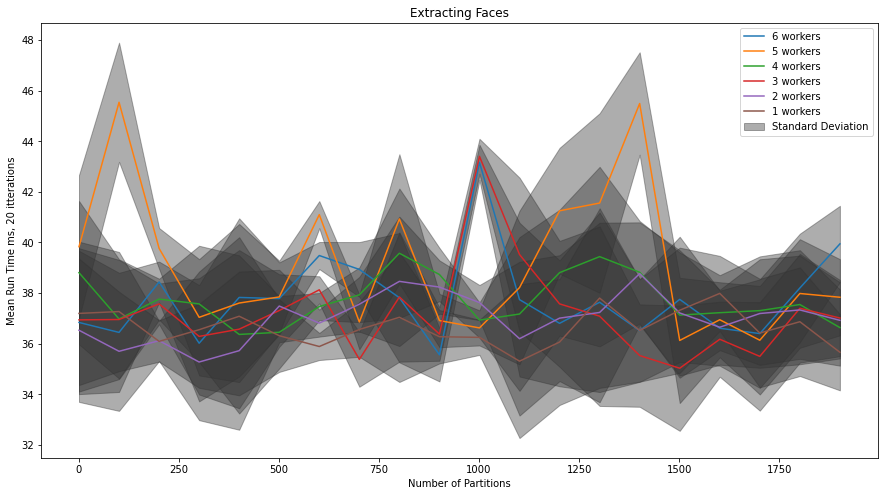

In [129]:
figPrePerf = plt.figure(figsize=(15,8))
for i in np.arange(6,0,-1):
    times = preamble_perf['times_'+str(i)+'w']
    plt.plot(partitions, times,label=str(i)+' workers')
    if i == 1: plt.fill_between(partitions,times+std,times-std, label='Standard Deviation', color=(0.2,0.2,0.2,0.4))
    else: plt.fill_between(partitions,times+std,times-std, color=(0.2,0.2,0.2,0.4))
plt.xlabel('Number of Partitions')
plt.ylabel('Mean Run Time, microseconds, '+str(it)+' itterations')
plt.title('Extracting Faces')
plt.legend()

In [132]:
print('Over every partition size tested the workers had an average run time of:')
for i in range(1,7):
    print(i,'workers:',np.mean(preamble_perf['times_'+str(i)+'w']))

Over every partition size tested the workers had an average run time of:
1 workers: 36.62310848303605
2 workers: 37.00209655857179
3 workers: 37.17949575569946
4 workers: 37.73247643315699
5 workers: 39.08042790892068
6 workers: 37.795326153282076


### Loading Time Test
This test aimes to discern how long it takes a worker to load the entire dataset one partition at a time for different number of partitions.

It applies the same partition test as before but this time a dummy function is used instead of the preamble. The duumy finction does nothing but return a dataframe that it is given. The time taken to perform this simple task should be close to the laoding time. 

Number of workers should be 1, it is: 1


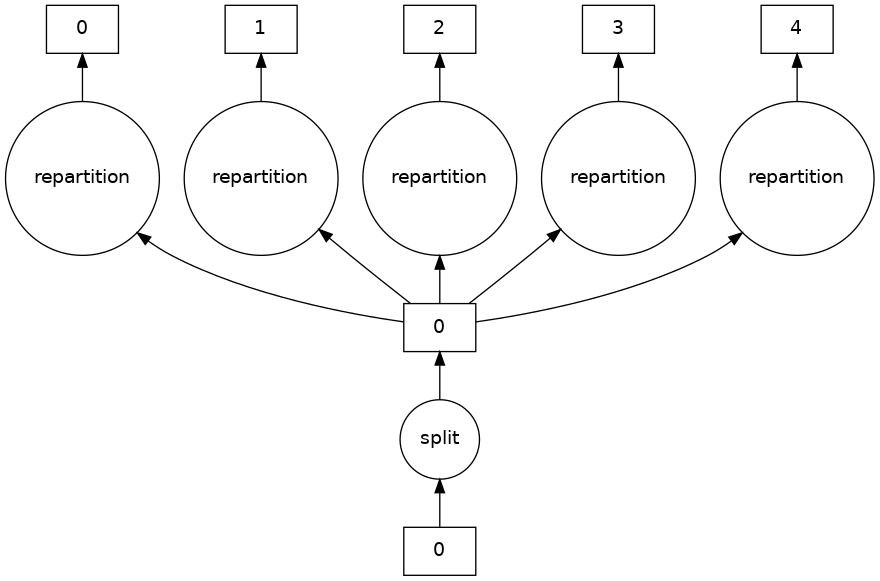

In [143]:
# after running the above code there should be one worker left
print('Number of workers should be 1, it is:',len(client.scheduler_info()['workers'].keys()))

#visualizing the nothing graph for 5 partitions to ensure there is nothing happening and it is distributed.
def nothing(df,meta): 
    return df
df, meta = loadData()
df = df.persist()
df = df.repartition(5)
dfno = nothing(df,meta)
dfno.visualize()


In [ ]:
times, std = partitionTest(nothing,partitions,itterations)

In [134]:
times = times*1000
std = std*1000

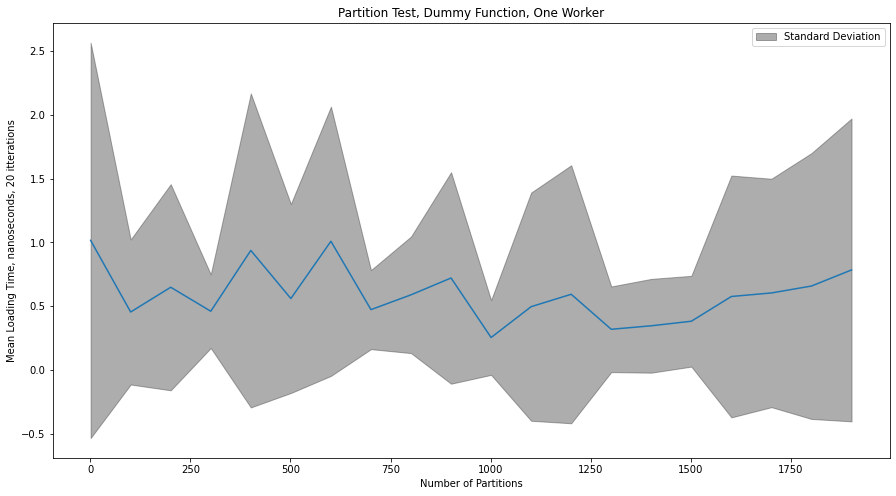

In [138]:
plt.figure(figsize=(15,8))
plt.plot(partitions,times)
plt.fill_between(partitions,times+std,times-std, label='Standard Deviation', color=(0.2,0.2,0.2,0.4))
plt.xlabel('Number of Partitions')
plt.ylabel('Mean Loading Time, nanoseconds, '+str(it)+' itterations')
plt.title('Partition Test, Dummy Function, One Worker')
plt.legend()

In [145]:
df, meta = loadData()
pd_df = df.compute()
print('The entire pandas dataframe is,',np.sum(pd_df.memory_usage())/1000,'kB')

The entire pandas dataframe is, 134.656 kB


### Discussion on the Preamble Partition Test Results
In this case the number of partitions does not have a noticable effect on the run time. The number of workers did not have a noticeable effect on run time either. The memory size of the entire dataset is 134kB and so when split between the partitons it is even smaller. This means that loading into ram is always very fast and splitting it cannot help loading speeds. This is shown in the partition test on the dummy function as well. This showed the time taken to load all the data by one worker is on the order of 0.5 nanoseconds regardless of the number of partitions. Processing time is on the order of 37 microseconds, thus loading time has a negligable effect. The processing time fluctuates wildly between around 34 and 45 microseconds. This could be caused by small thermal fluctuations within the processors or other external effects. It is safe to say the fluctuations have no bearing on number of partitions or number of workers.

It is expected that when scalling to larger data sizes the loading and processing times should have noticable differences for numbers of partitions and number of workers.

# Determining Image Size
A deep learning model must accept data of the same size. So we will rescale all of our images to this size. The mode of the max box dimension will be used as our default image size.

The distrobuted process is invesigated with visualizations. The performance is not of interest in this section.

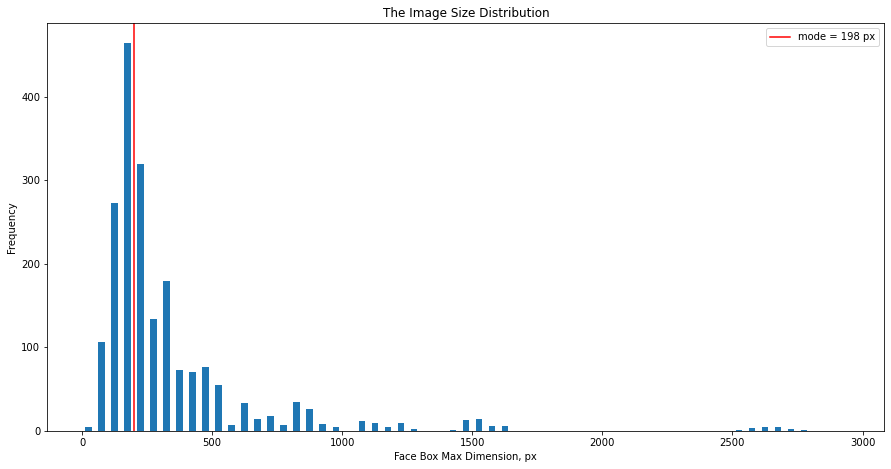

In [147]:
df, meta = loadData()
df, meta = preamble(df,meta)
max_box_dim = df['max_box_dim'].to_dask_array()
box_dim_mode = df['max_box_dim'].mode().compute()[0]
bins = np.arange(0,3000,50)
h, bins = da.histogram(max_box_dim,bins)
bincenter = (bins-25)[1:]
figimgsz = plt.figure(figsize=(15,7.5))
plt.bar(bincenter,h.compute(),width=25)
plt.axvline(box_dim_mode, color = 'red', label='mode = '+str(box_dim_mode)+' px')
plt.title('Image Size Distribution')
plt.xlabel('Face Box, Max Dimension, px')
plt.ylabel('Frequency')
plt.legend()

### Visualization of Distributed Mode Process

In the reduction chunk I suspect the data is reduced to the frequency of each number. Each worker doesn't know the frequencies calculated by the other workers. Thus a worker is given the task of collecting the results, summing them together and reducing it into one most frequently apparent value. 

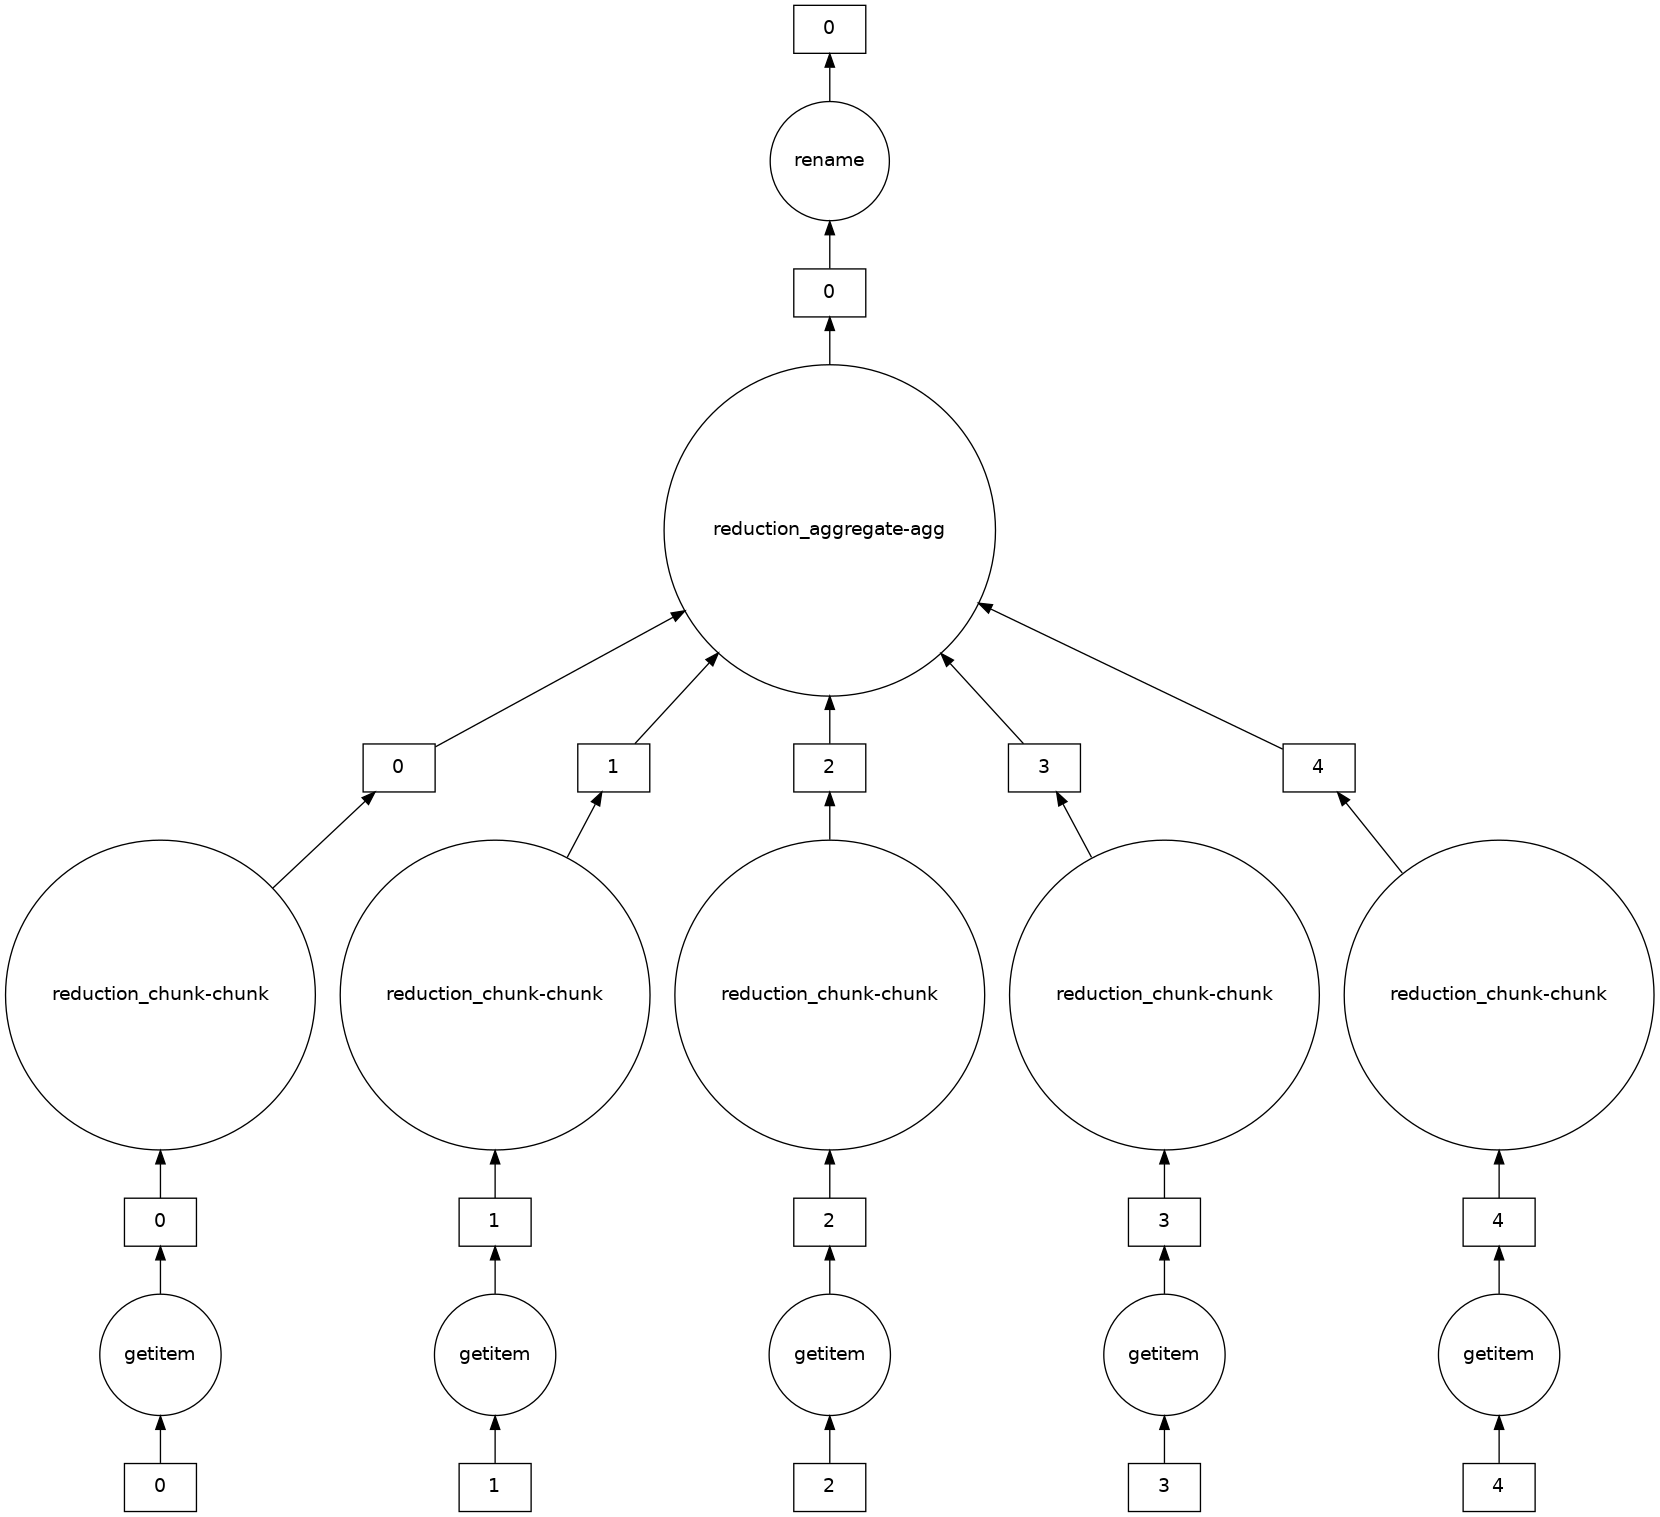

In [152]:
df = df.persist()
df = df.repartition(npartitions=5).persist()
box_dim_mode = df['max_box_dim'].mode()
box_dim_mode.visualize()

### Visualization of Distributed Histogram Process

In the histogram sum nodes I suspect the workers are summing up the frequencies in each bin. They don't know what frequencies the other workers have summed. The workers results have to be summed. Dask has decided to do this in two steps. Have two workers collect different results and sum them. Then have a final worker sum the result of these two. The partital sum seems to be imbalanced. One worker sums 4 sets of the results whilst another only has one. It is shown by increasing the number of partitions dask finds a better balance. 

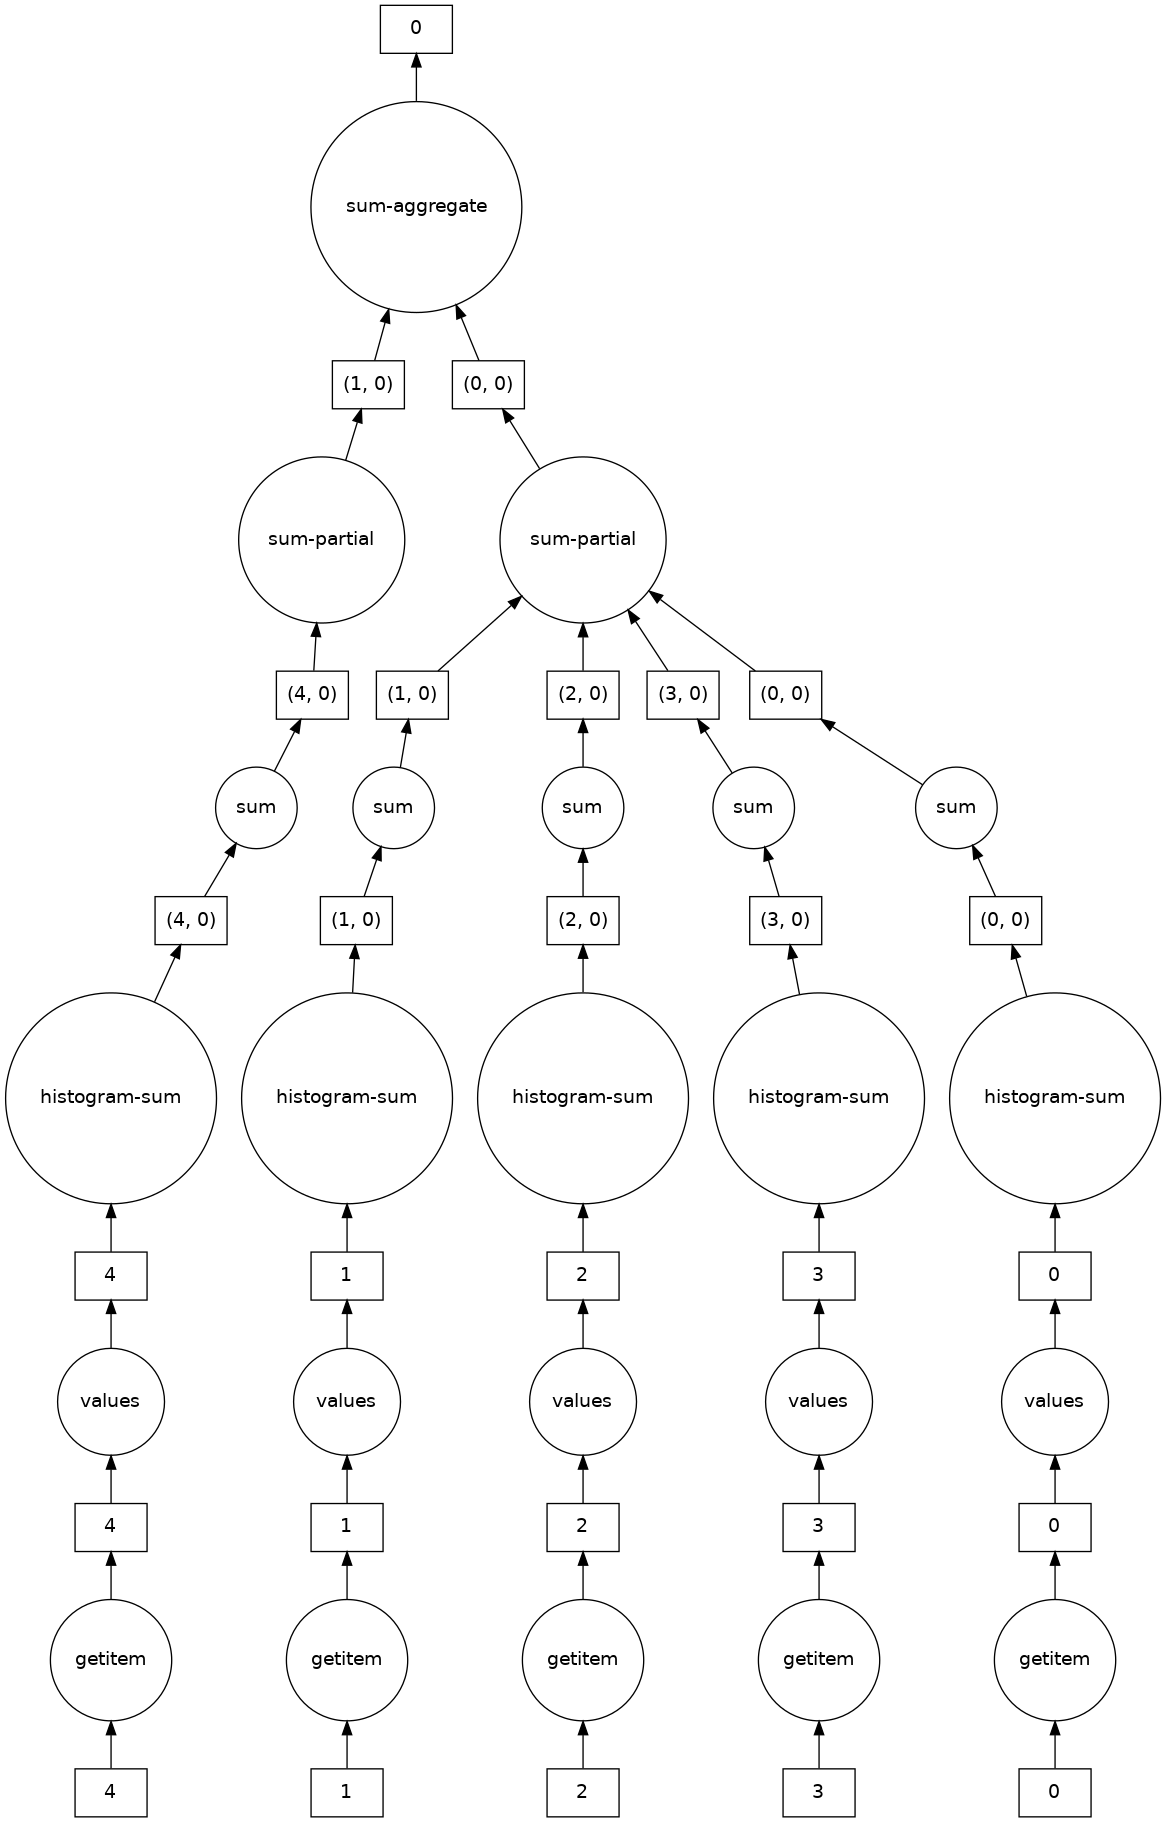

In [158]:
df, meta = loadData()
df, meta = preamble(df,meta)
df = df.repartition(5).persist()
max_box_dim = df['max_box_dim'].to_dask_array()
h, bins = da.histogram(max_box_dim,bins)
h.visualize()

### 8 partitions
It was strange that dask had one worker do 4 sums and another do 1. To investigate a little further I tried 8 partitions. With 8 partitions dask spread the partial sum more evenly.

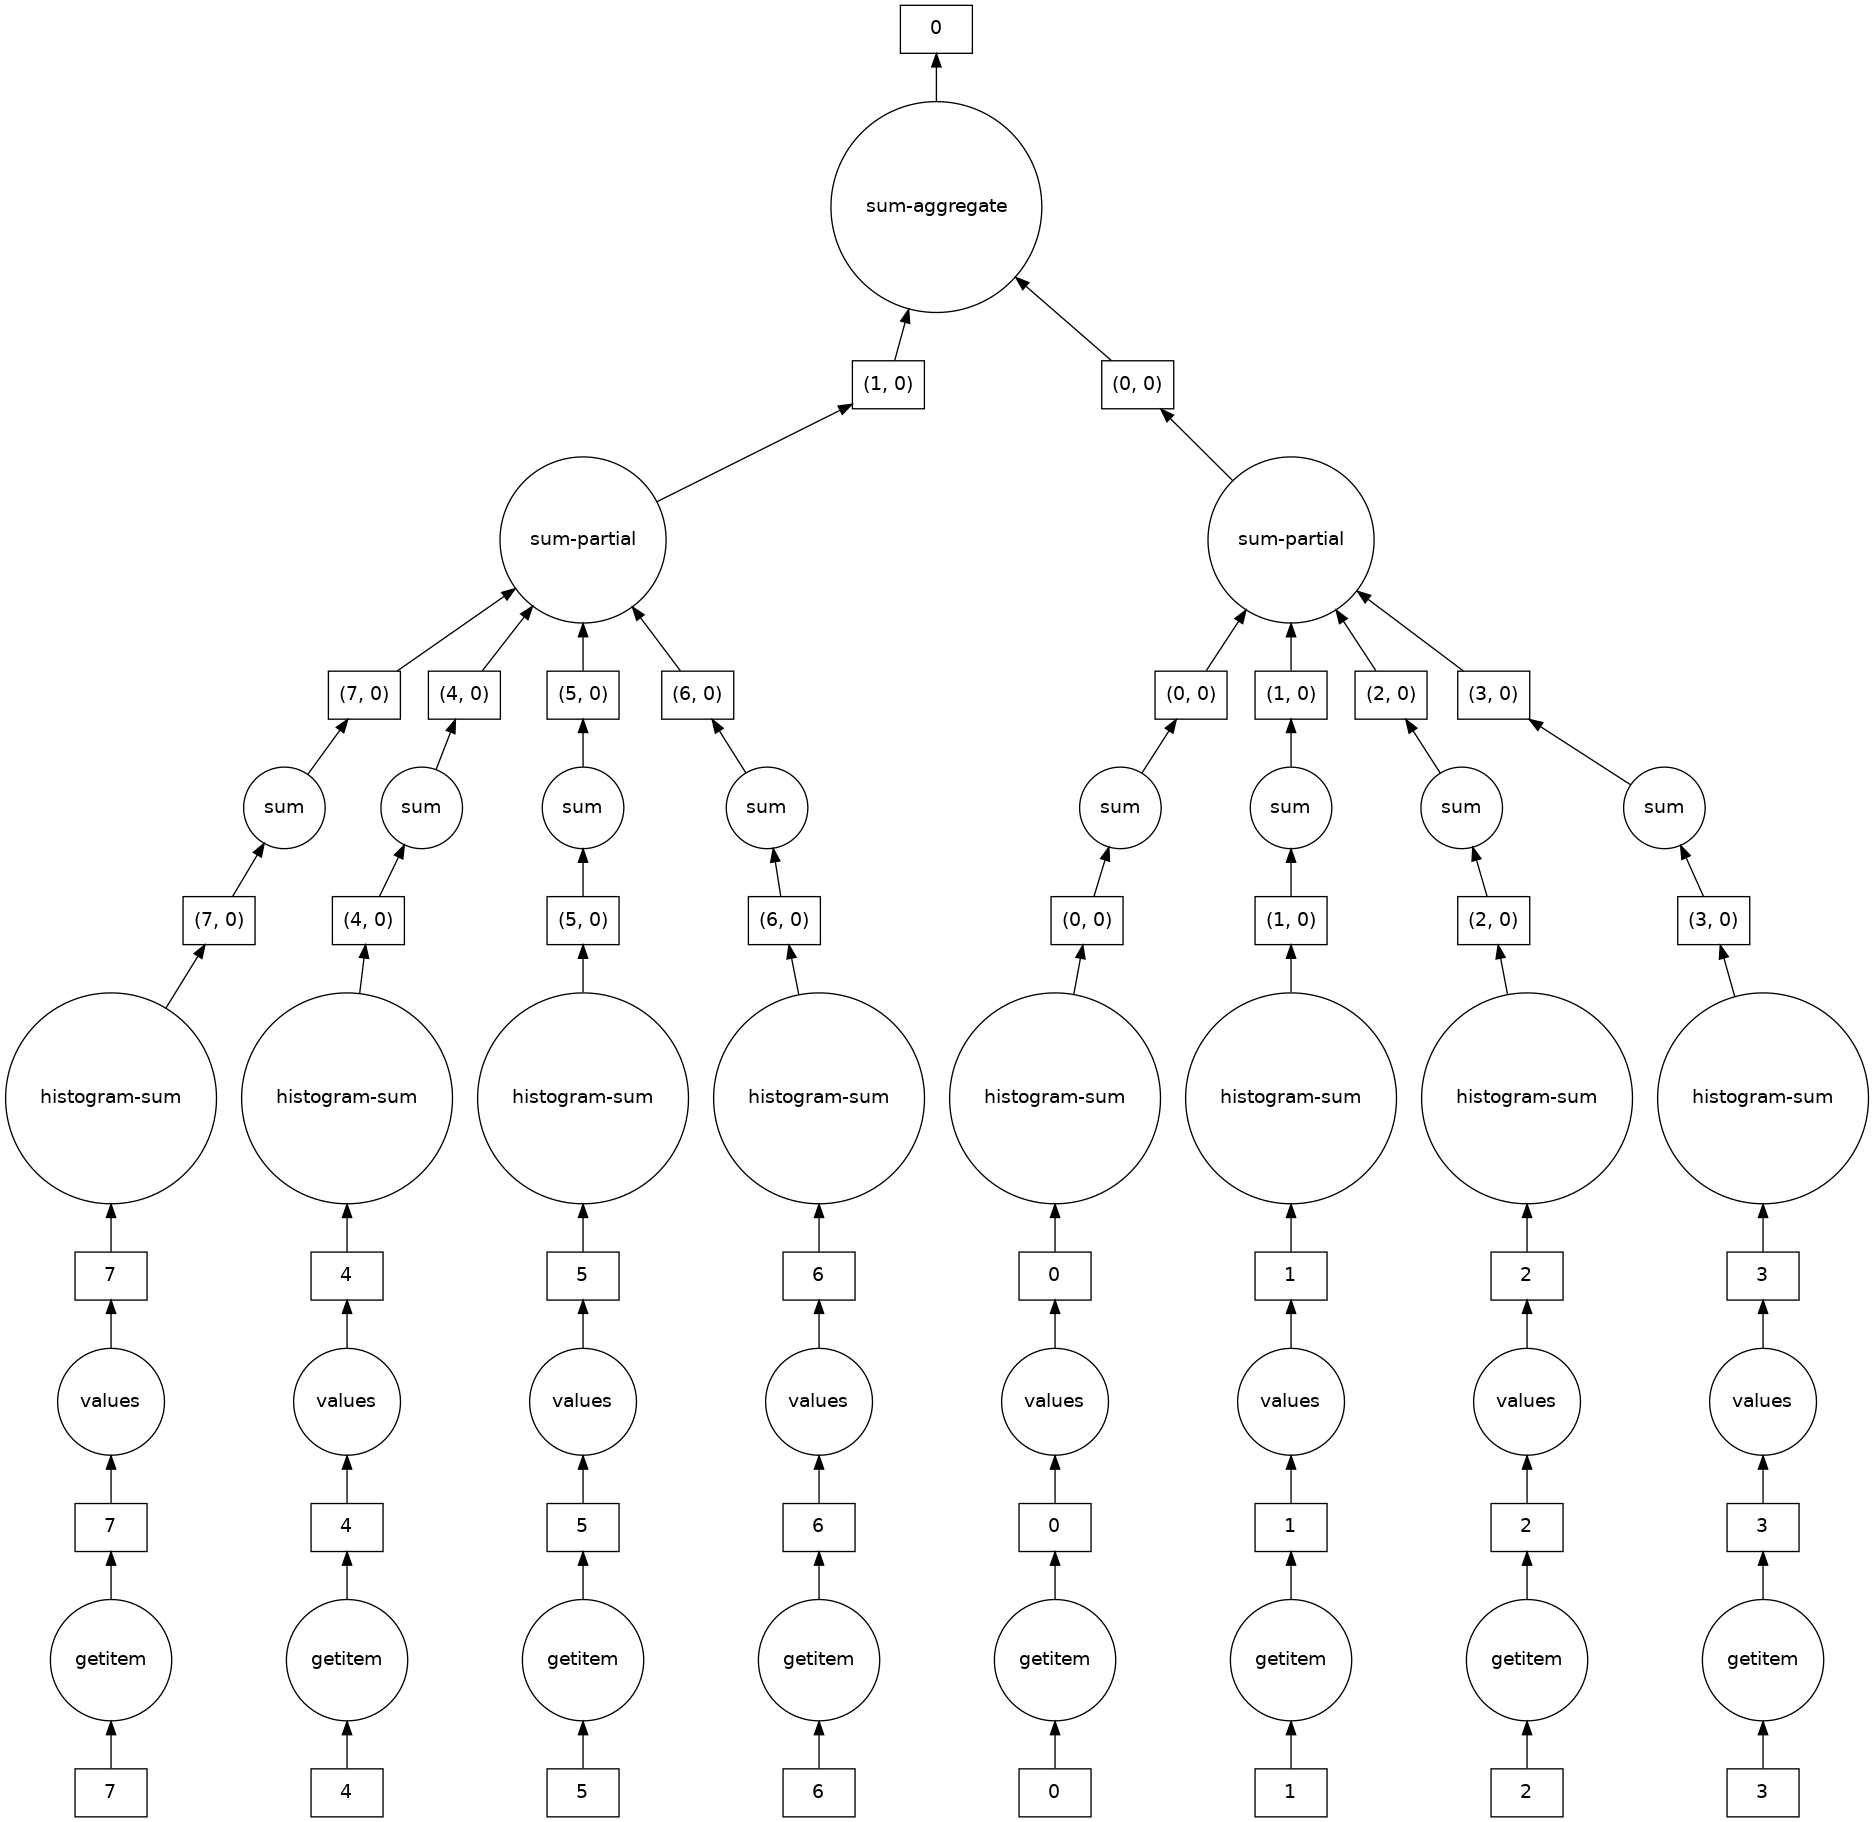

In [157]:
df, meta = loadData()
df, meta = preamble(df,meta)
df = df.repartition(8).persist()
max_box_dim = df['max_box_dim'].to_dask_array()
h, bins = da.histogram(max_box_dim,bins)
h.visualize()

The mode of the max box dimensions is:  198
This will be our default image width and height for the ML model


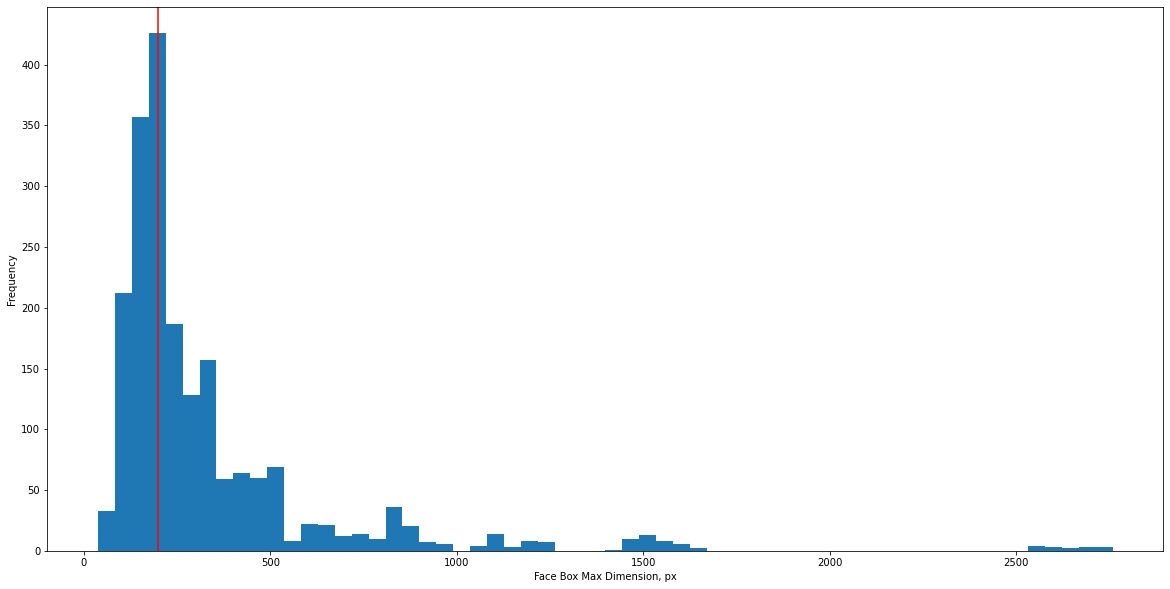

In [20]:

fig = plt.figure(figsize=(20,10))
plt.hist(df['max_box_dim'].compute(), bins = 60, log = False)
box_dim_mode = df['max_box_dim'].mode().compute()[0]
plt.axvline(box_dim_mode, color = 'red')
plt.xlabel('Face Box Max Dimension, px')
plt.ylabel('Frequency')
print('The mode of the max box dimensions is: ',box_dim_mode)
print('This will be our default image width and height for the ML model')

# Image Processing
The data in the dask data frame will be used to crop and resize the turtle images to 198x198. The turtle face will be extracted from each photo to create the Face samples. A random portions of each photo, the same size as the face portion, will be selected to create to noFace samples.

To accomplish this the face information of the data frame needs to be linked with it's corrosponding image. If I load all of the images into a dask array. It is impossable to know their order and how they match up with the dataframes information.

The first approach to overcome this is to go through each row of the dask dataframe and load the corrosponding image, manipulate it and then add it to a dask array for further processing. This works but adds an unecessary amount of reading time to the process.

The second approach is to load the images into the dataframe as a column. Then it is already there close to the face information. And can be used multiple times without the need to reload the images. This significantly increases the size of the datframe and so a small number of partitions can kill the workers.


# Getting the Face Images

The ML model will be trained to classify partial images of turtles into face and noFace. The provided images of turtles will be processed to extract the turtles faces. Labels have been provided represent a box surrounding the turtles face in each image. The boxes are not square. The ML model needs all the images to be the same size. To overcome this the shorter side is made equal to the longer size and the image is cropped to the new box. 

The next code cell will do the following:
 - run a function getFace on each dask dataframe partition, which is a pandas dataframe
 (Each partition can be ran on a different core/thread)
    - run a function getFace2 on each row of the partition.
        - This function will load the image associated with the row
        - Crop the image to a square the box that is mostly taken up by the turtles face
        - Save the new image to a file. 

In [8]:
def partestimg(df,partitions,itterations):
    times = np.empty(len(partitions))
    std = np.empty(len(partitions))
    count = 0
    for part in partitions:
        print('npartition being tested: ',part)
        count+=1
        df = df.repartition(npartitions=part)
        time2 = []
        for i in itterations:
            t1 = time.time()
            df2 = df.persist()
            wait(df2)
            t2 = time.time()
            time2.append(t2-t1)
        times[count-1] = np.mean(time2)
        std[count-1] = np.std(time2)
        print('Test done')
    return times, std

In [ ]:
facedf = facedf.persist()
wait(facedf)
a=1

In [83]:
pdface = facedf.compute()
pdface

In [89]:
print(len(pdface))

1999


# Face Extraction Partition Test

In [ ]:
partitions = np.arange(1,4,1)
itterations = range(3)
workers = client.scheduler_info()['workers'].keys()
exFperf = pd.DataFrame({'partitions':np.array(partitions)})
for worker in workers:
     nw = len(client.scheduler_info()['workers'].keys())
     print('retireing',nw)
     client.retire_workers(workers=[worker])
     print('retired')
     times, std = partestimg(facedf,partitions,itterations)
     exFperf['times_'+str(nw)+'w'] = times
     exFperf['std_'+str(nw)+'w'] = std
exFperf

5
retired
1
done
2
done
3
done
4
retired
1


In [20]:
exFperf

,partitions,times_5w,std_5w,times_4w,std_4w,times_3w,std_3w,times_2w,std_2w,times_1w,std_1w
0,1,82.978912,117.298780,88.345612,124.887761,86.932717,122.889819,85.526458,120.895467,86.223210,121.886604
1,2,0.027269,0.014853,0.032089,0.021433,0.042768,0.032463,0.047109,0.042439,0.027526,0.015699
2,3,0.024599,0.010938,0.037419,0.004744,0.030684,0.011728,0.029404,0.010055,0.027046,0.013705


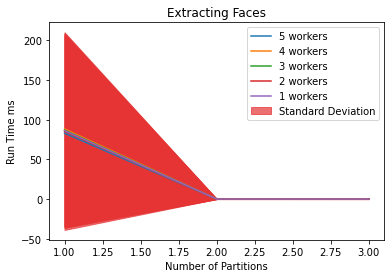

In [26]:
partitions = exFperf['partitions']
for i in np.arange(1,500,50):
    times = exFperf['times_'+str(i)+'w']
    plt.plot(partitions, times,label=str(i)+' workers')
    if i == 1: plt.fill_between(partitions,times+std,times-std, label='Standard Deviation', color=(0.9,0.2,0.2,0.7))
    else: plt.fill_between(partitions,times+std,times-std, color=(0.9,0.2,0.2,0.7))
plt.xlabel('Number of Partitions')
plt.ylabel('Run Time ms')
plt.title('Extracting Faces')
plt.legend()


Text(0.5, 1.0, 'Extracting Faces')

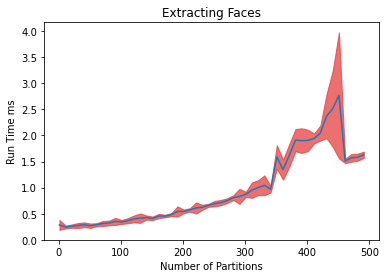

In [12]:
#timesall = np.concatenate(times,times2/1000)
#stdall = np.concatenate(std,std2/1000)
#times = times * 10**5
#std = std *10**5
plt.plot(partitions, times)
plt.fill_between(partitions,times+std,times-std, label='Standard Deviation', color=(0.9,0.2,0.2,0.7))
plt.xlabel('Number of Partitions')
plt.ylabel('Run Time ms')
plt.title('Extracting Faces')

In [36]:
import os
alldf = pd.DataFrame()
useddiff = []
for i in range(len(write)):
    tot_m, used_1, free_m = map(int, os.popen('free -t').readlines()[-1].split()[1:])
    row = pd.read_csv('faces.csv',skiprows=i,nrows=1)
    tot_m, used_2, free_m = map(int, os.popen('free -t').readlines()[-1].split()[1:])
    diff = used_2-used_1
    useddiff.append(diff)
    #pandas.concat([alldf,row])

In [38]:
facedf.visualize()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.455179 to fit


In [13]:
%%time
from time import sleep
#sleep(1)
memtest = facedf.compute()

CPU times: user 1.67 s, sys: 333 ms, total: 2.01 s
Wall time: 2.74 s


In [16]:
memtest

,box_topleft_x,box_topleft_y,box_width,box_height,image_width,image_height,box_bottomright_x,box_bottomright_y,max_box_dim,file_path,face_number,face_img
filename,,,,,,,,,,,,
Image_10.jpg,3232,777,874,848,5616,2633,4106,1625,874,daskShared_local/images/Image_10.jpg,10,"[[[[ 0 196 244], [ 0 196 244], [ 0 197 245]..."
Image_100.jpg,283,136,158,120,800,505,441,256,158,daskShared_local/images/Image_100.jpg,100,"[[[[52 68 65], [49 66 61], [48 68 61], [55 78 ..."
Image_1000.jpg,228,184,156,160,500,559,384,344,160,daskShared_local/images/Image_1000.jpg,1000,"[[[[ 78 180 182], [ 77 180 181], [ 76 180 181]..."
Image_1001.jpg,1721,517,1552,1636,4631,3087,3273,2153,1636,daskShared_local/images/Image_1001.jpg,1001,"[[[[ 20 94 240], [ 20 94 240], [ 20 94 240]..."
Image_1002.jpg,517,239,340,224,1200,900,857,463,340,daskShared_local/images/Image_1002.jpg,1002,"[[[[ 59 179 196], [ 50 177 196], [ 36 173 187]..."
...,...,...,...,...,...,...,...,...,...,...,...,...
Image_995.jpg,446,219,178,192,1200,630,624,411,192,daskShared_local/images/Image_995.jpg,995,"[[[[ 25 98 167], [ 22 95 164], [ 25 98 167]..."
Image_996.jpg,1851,598,1251,1202,4752,3168,3102,1800,1251,daskShared_local/images/Image_996.jpg,996,"[[[[58 68 75], [60 72 75], [64 75 77], [60 68 ..."
Image_997.jpg,724,433,433,357,2119,1414,1157,790,433,daskShared_local/images/Image_997.jpg,997,"[[[[ 91 141 174], [ 89 142 174], [ 94 147 179]..."


In [41]:
imgar = memtest['face_img'].iloc[0][0]
print("%d bytes" % (imgar.size * imgar.itemsize))

117612 bytes


In [44]:
imgar2 = memtest['face_img'].iloc[1][0]
print("%d bytes" % (imgar.size * imgar.itemsize))

117612 bytes


In [45]:
import os
tot_m, used_m, free_m = map(int, os.popen('free -t -m').readlines()[-1].split()[1:])
used_m

1668

# Getting the noface images

The ML model will be trained to classify partial images of turtles into face and no face. The provided images of turtles will be processed to extract sections of those images that do not contain a face. To do this the information in the dataframe of the face location is required.

The next code cell will do the following:
 - run a function getNoFace on each dask dataframe partition which is a pandas dataframe
 (Each partition can be ran on a different core/thread)
    - run a function getNoFace2 on each row of the partition.
        - This will load the image associated with the row
        - split it into four images, one on each side of the turtle face box, these images are called sides
        - Take the largest of these four sides and take a random chunck about the same size as the face box. This is the extracted noFace image. (This makes sure the no face images are as similar as possible to the face image, in terms of resolution and amount of the turtle visable)
        - Sometimes the largest side is smaller then the face box. In this case the largest random square is taken as the noFace Image.
        - The noFace image extraced is resized to 198 by 198 pixels. (This is the mode of the largest facebox dimension, and so most of the face images are limited to this ammount of imformation.)
        - The the new noFace image is then saved to a file.
 

In [242]:
client

Connection method: Direct,


In [237]:
#te = data.partitions[0:4].compute()
allf = te['face_img'].values
print(type(allf))
faces = [i[0] for i in allf]
faces = np.array(faces)
np.shape(faces)

<class 'numpy.ndarray'>


(7, 198, 198, 3)

In [141]:
f = open('test.txt','w')
f.write('3'+','+'4') #Give your csv text here.
## Python will convert \n to os.linesep
f.close()

In [142]:
! cat test.txt

3,4

In [12]:
client

Connection method: Direct,


In [31]:
client.has_what()

{'tcp://10.67.22.178:38677': ("('split-d3b2e3c3ce7c5ecdaf18b1e6d6596a68', 0)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 268)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 236)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 208)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 314)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 352)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 387)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 55)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 51)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 931)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 247)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 234)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 190)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 610)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 470)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 399)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 261)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 867)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 851)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 212)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 239)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 97)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 364)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 167)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 938)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 24)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 432)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 762)",
  "('repartition-1000-df50dda4b71e857353e774b357a15eb0', 289)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 301)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 406)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 854)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 34)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 839)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 480)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 126)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 187)",
  "('repartition-1000-df50dda4b71e857353e774b357a15eb0', 53)",
  "('repartition-1000-df50dda4b71e857353e774b357a15eb0', 319)",
  "('repartition-1000-df50dda4b71e857353e774b357a15eb0', 797)",
  "('repartition-1000-df50dda4b71e857353e774b357a15eb0', 513)",
  "('repartition-1000-df50dda4b71e857353e774b357a15eb0', 216)",
  "('repartition-1000-df50dda4b71e857353e774b357a15eb0', 965)"),
 'tcp://10.67.22.193:35375': ("('split-d3b2e3c3ce7c5ecdaf18b1e6d6596a68', 0)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 394)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 54)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 166)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 596)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 89)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 227)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 701)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 775)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 589)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 47)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 916)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 698)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 60)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 551)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 363)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 577)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 127)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 697)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 576)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 585)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 112)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 744)",
  "('repartition-1000-df50dda4b71e857353e774b357a15eb0', 289)",
  "('getNoFace-a15fabc25f37f872604360e9aedd8ab9', 271)",
  "('getNoFace-a15fabc25f37f87260

In [581]:
from dask.array.image import imread
face = imread('/home/ubuntu/daskShared_local/face/face*')
noface = imread('/home/ubuntu/daskShared_local/noface/noface*')
display(face)
display(noface)
data = [face,noface]
data = da.stack(data,axis=1)
display(data)

,Array,Chunk
Bytes,224.21 MiB,114.86 kiB
Shape,"(1999, 198, 198, 3)","(1, 198, 198, 3)"
Count,1999 Tasks,1999 Chunks
Type,uint8,numpy.ndarray


,Array,Chunk
Bytes,224.21 MiB,114.86 kiB
Shape,"(1999, 198, 198, 3)","(1, 198, 198, 3)"
Count,1999 Tasks,1999 Chunks
Type,uint8,numpy.ndarray


,Array,Chunk
Bytes,448.43 MiB,114.86 kiB
Shape,"(1999, 2, 198, 198, 3)","(1, 1, 198, 198, 3)"
Count,7996 Tasks,3998 Chunks
Type,uint8,numpy.ndarray


In [69]:
#chunk = (100,198,198,3)
block_size_limit = 500e6#bytes
face = da.rechunk(face,block_size_limit)
noface = da.rechunk(noface,block_size_limit)

perc_tr = 0.8
nimg = len(face)
m_tr = int(nimg*perc_tr)

#lables will be made later just before going into the CNN this way I can be sure the lables are not places on different workers than the corresponding data
face_tr = face[:m_tr]
face_val = face[m_tr:]
noface_tr = noface[:m_tr]
noface_val = noface[m_tr:]

#save the validation data to the shared folder so all workers have access
da.to_npy_stack('/home/ubuntu/daskShared_local/face_val.npy', face_val, axis=0)
da.to_npy_stack('/home/ubuntu/daskShared_local/noface_val.npy', noface_val, axis=0)

In [59]:
face_val2 = da.from_npy_stack('/home/ubuntu/daskShared_local/face_val.npy')
face_val2

dask.array<from-npy-stack, shape=(400, 198, 198, 3), dtype=uint8, chunksize=(400, 198, 198, 3), chunktype=numpy.ndarray>

In [65]:
import dask.bag as db
b = db.from_sequence([{'face':np.ones((4,4))}, 2, 3, 4, 5, 6])

In [62]:
face.to_

TypeError: 'Bag' object is not subscriptable

In [43]:
face = face.persist()
wait(face)

DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('rechunk-merge-150c01f6c6736488ac13c66fb7e2f08a', 0, 0, 0, 0)>}, not_done=set())

In [48]:
da.to_npy_stack('/home/ubuntu/daskShared_local/face_val/face_val.npy', face, axis=0) 


SyntaxError: unexpected EOF while parsing (4138199870.py, line 3)

dask.array<from-npy-stack, shape=(1999, 198, 198, 3), dtype=uint8, chunksize=(1999, 198, 198, 3), chunktype=numpy.ndarray>

In [45]:
face.to_zarr('/home/ubuntu/daskShared_local/face.zarr',compute=True)

ModuleNotFoundError: No module named 'zarr'

In [ ]:
face.to_hdf5('/home/ubuntu/daskShared_local/face.hdf5','/datapath',chunks = face.chunksize)

In [39]:
print(type(face.chunksize))
face.chunksize

<class 'tuple'>


(1999, 198, 198, 3)

In [ ]:
face_tr = 

# Distributed Tensorflow CNN

In [ ]:
pdf = data.compute()

In [ ]:
data = data.set_index('face_number')

In [8]:
# marcos cnn model
def build_cnn():
    cnn = models.Sequential([
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        #dense
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    # compile
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #summary
    #print(cnn.summary())
    return cnn

#function to turn a pandas partition of the data into a form the model will accept
def extractData(pdf):
    faces = pdf['face_img'].tolist()
    faces = [i[0] for i in faces]
    faces = np.array(faces)
    labelsF = np.ones(len(faces))    
    nofaces = pdf['noFace_img'].tolist()
    nofaces = [i[0] for i in nofaces]
    nofaces = np.array(nofaces)
    labelsNF = np.zeros(len(nofaces))
    data = np.concatenate((faces,nofaces), axis = 0)
    labels = np.concatenate((labelsF,labelsNF))
    return data, labels

#a delayed function to be applyed to each partition of the dd that hold the validation data
#The returned futures can then be converted into a form marco's model will accept  
@dask.delayed
def extractValData(pdf):
    data, labels = extractData(pdf)
    val = pd.DataFrame()
    val['v_data'] = [data]
    val['v_labels'] = [labels]
    return (data,labels)

# seperating into training and validation sets. Then brining the validation to the working machine
#too high and it will crash the workers, too low and our validations are innaccurate
n_rows = 400#marco did 400
v_ind = [str(i) for i in range(2,n_rows+2)]
t_ind = [str(i) for i in range(n_rows+2,len(data))]
v_data = data.loc[v_ind]
t_data = data.loc[t_ind]

v_data = v_data.repartition(npartitions=100)
v_meta = pd.DataFrame()
v_meta['v_data'] = [np.ones((2,2))]
v_meta['v_labels'] = [np.ones((2,2))]

v_data_futures = []
for partition in v_data.partitions:
    future = extractValData(partition)
    v_data_futures.append(future)

v_data = [future.compute() for future in v_data_futures]
v_labels = np.concatenate([i[1] for i in v_data])
v_data = np.concatenate([i[0] for i in v_data],axis = 0)



In [9]:
n_rowsper_part = 5
n_rows = len(t_data)
n_part = n_rows//n_rowsper_part
t_data = t_data.repartition(npartitions=n_part)

In [10]:
t_data = t_data.persist()
wait(t_data)
a = 5

In [11]:
# def train(partition):
#     #data, labels = extractData(partition)
# #     cnn = cnn.set_weights(weights)
# #     fit = cnn.fit(data,labels, epochs = epochs)
# #     weights = cnn.get_weights()
# #     loss, acc = fit.validate(v_data, v_labels)
# #     results = pd.DataFrame()
# #     results['acc'] = acc
# #     results['weights'] = weights
#     res = pd.DataFrame()
#     res['type'] = type(partition)
#     #res['labels'] = [labels]
#     return res
# t_d = t_data.partitions[0:3]
# # cnn = build_cnn()
# # weights = cnn.get_weights()
# #epochs = 10
# tr_meta = pd.DataFrame()
# tr_meta['type'] = type(pd.DataFrame)
# #tr_meta['lables'] = [np.ones(4)]
# res = t_d.map_partitions(train, meta = tr_meta)
# # cnn = build_cnn()
# # init_weights = cnn.get_weights()
# # test = data.partitions[0]
# # meta = pd.DataFrame(data=[0.1,init_weights],columns=['accuracy','weights'])

# # test.map_partitions(train,(cnn),meta = meta).compute()

In [ ]:
for i in range(len(v_data)):
    print(i)
    vd_small = v_data[:i]
    vl_small = v_labels[:i]
    vd_small = client.scatter(vd_small)
    vl_small = client.scatter(vl_small)

In [12]:
vd_small = v_data[:50]
vl_small = v_labels[:50]
vd_small = client.scatter(vd_small)
vl_small = client.scatter(vl_small)

In [24]:
print(vl_small.result())

1.0


In [101]:
ls = v_labels[0:2]
ds = v_data[0:2]

In [77]:
face_tr = face_tr.rechunk(block_size_limit=500e6)
face_tr = face_tr.persist()
wait(face_tr)

DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('getitem-3887ac5f28f8e5a8f40f294a4c2f64c8', 0, 0, 0, 0)>}, not_done=set())

In [111]:
face_del = face_tr.to_delayed(optimize_graph=True)
face_dell = face_del[0][0][0][0][0]
face_dell = face_dell
for i in :
    print(type(i.compute()))

TypeError: Delayed objects of unspecified length are not iterable

In [101]:
from dask import delayed
a = delayed([1, 2, 3],nout=3)
#a.compute()
@dask.delayed
def addone(a): return a+5

b = [0,0,0,0]
ind = 0
for i in a:
    ind += 1
    b[ind] = addone(i)
b[1].compute()

6

In [116]:
one = np.empty((5,5))
rand = np.random.rand(5,5)
print("Memory size of numpy array in bytes:",
      one.size * one.itemsize)
print("Memory size of numpy array in bytes:",
      rand.size * rand.itemsize)
rand

Memory size of numpy array in bytes: 200
Memory size of numpy array in bytes: 200


array([[0.44206335, 0.07326896, 0.46582981, 0.02586143, 0.71714004],
       [0.56158517, 0.91167374, 0.60290554, 0.61472775, 0.89854242],
       [0.18914889, 0.68141395, 0.45316029, 0.82427203, 0.38223206],
       [0.05487287, 0.09222751, 0.74676066, 0.1732602 , 0.13580636],
       [0.6817878 , 0.6469847 , 0.07478749, 0.56340787, 0.64465204]])

In [70]:
import dask.bag as db
@dask.delayed
def train(partition, weights, v_data, v_labels):#, cnn, v_data, v_labels, weights, epochs):
    cnn = build_cnn()
    cnn.set_weights(weights)
    data, labels = extractData(partition)
    fit = cnn.fit(data,labels, epochs = 1)
    weights = cnn.get_weights()
    loss, acc = cnn.evaluate(v_data, v_labels)
    return (acc,weights)


# def evalu(weights, v_data, v_labels):
#     cnn = build_cnn()
#     #cnn.set_weights(weights)
#     #loss, acc = cnn.evaluate(v_data,v_labels)
#     return weights
    
t_d = t_data.partitions[0:3]
t_d = t_d.persist()
wait(t_d)
cnn = build_cnn()
weights = cnn.get_weights()
# #epochs = 10
results = []
for partition in t_d.partitions:
    results.append(train(partition, weights, vd_small, vl_small))#, cnn, v_data, v_labels, weights, epochs))
    
acc = [res.compute()[0] for res in results]
i_best = np.argmax(acc)
print(np.argmax(acc))
best_weights=results[i_best].compute()[1]

# results = []
# for partition in t_d.partitions:
#     results.append(train(partition, best_weights, vd_small, vl_small))
# # r_weights = db.from_delayed(r_weights)



# cnn = build_cnn()
# init_weights = cnn.get_weights()
# test = data.partitions[0]
# meta = pd.DataFrame(data=[0.1,init_weights],columns=['accuracy','weights'])

# test.map_partitions(train,(cnn),meta = meta).compute()

KeyboardInterrupt: 

In [68]:
print(acc)

[0.5199999809265137, 0.5199999809265137, 0.5199999809265137]


In [66]:
len(r_weights[2].compute()[1])

8

In [50]:
r_weights = r_weights.persist()
wait(r_weights)
a=1



In [ ]:
r_weights.compute()

In [47]:
print(len(r_weights.compute()[0]))

3


In [42]:
ans = db.map(evalu,r_weights,vd_small,vl_small)

In [46]:
print(len(ans.compute()[0]))

3


In [95]:
ans[0][1]

1.0

In [31]:
np.shape(v_labels)

(800,)

In [ ]:
db.map(lambda(print()))

In [70]:
db.map(lambda x: print(x), r_weights).compute()

TypeError: 'Bag' object is not subscriptable

In [67]:
shp = r_weights.map(evalu,(ds,ls))

In [ ]:
shp.compute()

In [17]:
res.result().result()

Delayed('result-ca148f49-a64a-41ba-9b85-0d867987c255')

In [169]:
len(ans)

TypeError: object of type 'type' has no len()

In [144]:
print(np.shape(v_data))

(800, 198, 198, 3)


In [131]:
np.shape(v_data_futures[3].compute()[0])

(10, 198, 198, 3)

In [52]:
test = v_data.partitions[0]
test = test.compute()
tdata, tlables = extractData(test)

In [56]:
tlables

array([1., 1., 1., 1., 0., 0., 0., 0.])

In [85]:
a = v_data.head()
print(type(a['v_data'][0]))

<class 'numpy.ndarray'>


In [75]:
print(len(v_data))

100


# Image Processing Performance

In the next cells the following tests will be deployed:

- Partition Test, monitoring the processing time at different numbers of partitions

- Memory Graphs, Showing the memory usage of a worker at 

# adding images to the dataframe for approach 2

In [19]:
df = loadData()
predf = preamble(df)
# only about 2 images per partition to prevent workors dying from memory overload
predf = predf.repartition(npartitions=1000)
def images(partition):
    def images2(row):
        im = io.imread(row['file_path'])
        return im
    partition['image'] = partition.apply(images2, axis = 1)
    return partition
columns = list(predf.columns.values)
columns.append('image')
meta = pd.DataFrame(data = [[1,2,3,4,5,6,7,8,9,Path('/~'),'facenumber',np.zeros(1)]],columns=columns)
imgdf = predf.map_partitions(images, meta = meta)
imgdf

,box_topleft_x,box_topleft_y,box_width,box_height,image_width,image_height,box_bottomright_x,box_bottomright_y,max_box_dim,file_path,face_number,image
npartitions=1000,,,,,,,,,,,,
,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


# Getting the face images approach 2

The only difference with the first approach is that now the images are in the dataframe with the face data. And so already loaded.

In [17]:
def partitionTest3(fun,df, partitions,itterations=1):
    times = []
    for i in partitions:
        print('Number of Partitions: ',i)
        df = df.repartition(npartitions = i)
        print('1')
        df = df.persist()
        print('2')
        times2 = []
        for j in range(itterations):
            t1 = time.perf_counter()
            workers = client.scheduler_info()['workers'].keys()
            print(workers)
            print('2.5')
            fun(df)
            print('3')
            t2 = time.perf_counter()
            times2.append(t2-t1)
        times.append(np.mean(times2))
    plt.plot(partitions,times)
    plt.xlabel('number of partitions')
    plt.ylabel('time taken in seconds')
    return seq, times

In [ ]:
from skimage import util
def getFace(partition):
    def getFace2(image_info):
        im = image_info['image'] #******************************* only line thats different
        im = im[:,:,:3]# remove fourth channel if it exists
        var = locals()
        y = image_info['box_topleft_y']
        x = image_info['box_topleft_x']
        dim = {'box_width':image_info['box_width'],'box_height':image_info['box_height']}
        max_dim_key = max(dim, key = dim.get)
        max_dim = image_info['max_box_dim']
        dif = np.abs(image_info['box_width'] - image_info['box_height'])
        half_dif = int(dif/2)
    
        if max_dim_key == 'box_width':
            new_top = y-half_dif
            new_bottom = new_top + max_dim
            pad_width = 0
            if(new_top < 0):
                pad_width = -new_top
                new_top = 0
            if(new_bottom > image_info['image_height']):
                pad_width = new_bottom - image_info['image_height']
                new_bottom = image_info['image_height']
        
            im = np.pad(im, pad_width = [(pad_width,pad_width),(pad_width,pad_width),(0,0)], mode = 'reflect')
            face = im[ new_top : new_bottom, x : x+max_dim, :]
            
        if max_dim_key == 'box_height':
            new_left = x-half_dif
            new_right = new_left + max_dim
            pad_width = 0
            if(new_left < 0):
                pad_width = -new_left
                new_left = 0
            if(new_left > image_info['image_width']):
                pad_width = new_left - image_info['image_width']
                new_left = image_info['image_width']
            im = np.pad(im, pad_width = [(pad_width,pad_width),(pad_width,pad_width),(0,0)], mode = 'reflect')
            face = im[ y : y+max_dim, new_left : new_right, :]
        path = Path('/opt','workspace','data','Faces3','face_'+image_info['face_number']+'.jpg')
        face = transform.resize(face,(198,198,3))
        face = util.img_as_ubyte(face)
        io.imsave(path,face)
    partition.apply(getFace2, axis = 1)

def face(facedf):
    meta = pd.DataFrame()
    facedf.map_partitions(getFace, meta = meta).compute()

partitions = [1000,500,250,125,50,6]
partitionTest3(face,imgdf,partitions)
plt.title('Getting Face Images Partition Test, approach 2')

# Scalling up

One great advantage of using a distributed system is the ability to process data of size beyond the ram limit of the resources. To test our code for multiple data sizes the data will be duplicated.

Ram Limit of system:
6 workers of 2GB each (1.9 for now)



In [33]:
#load all images into dataframe with large number of partitions
# save it to a parquet file
# predict the ram usage of the file
# use this to guess ideal partitions
# load it with lower numbers of partitions unitll it wont load without killing workers, this is min partitions
# do partition analysis from min and above

# The ram usage of the file tells us how many duplications will take us to the ram limit. 
# plot number of duplications as a function of ram size, make many parque files with different numbers of duplications

In [34]:
from dask.distributed import wait, progress
from time import sleep
#client.rebalance([predf.persist(), workers])
def minPartTest(df,start=1000,stop=1,step=100):
    print('Testing min partitions')
    for npart in reversed(range(stop,start,step)):
        print('testing: ',npart)
        df = df.repartition(npartitions=npart)
        df = df.persist() 
        wait
        workers = client.scheduler_info()['workers'].keys()
        if len(workers)==0:
            print('Broken at npartitions:',npart)
            break
    return df
        

In [35]:
predf = minPartTest(predf)

Testing min partitions
testing:  901
testing:  801
testing:  701
testing:  601
testing:  501
testing:  401
testing:  301
testing:  201
testing:  101
testing:  1


# dump

In [10]:
workers = client.scheduler_info()['workers'].keys()
print(len(workers))
#client.processing(workers)

6


In [12]:
# min number of partitions finder.
# does reshuffling help

from dask.distributed import wait, progress
wait

<function distributed.client.wait(fs, timeout=None, return_when='ALL_COMPLETED')>

In [ ]:
from skimage import io, transform
import numpy as np
from pathlib import Path

for i in range(1,2104):
        if (i%100==0): print(i)
        try: im = io.imread(Path('data/noFaces2/Image_'+str(i)+'.jpg'))    
        except:
            try: im = io.imread(Path('data/images/Image_'+str(i)+'.jpeg'))
            except:
                try: im = io.imread(Path('data/images/Image_'+str(i)+'.png'))
                except:
                    try: io.imread(Path('data/images/Image_'+str(i)+'.JPG'))
                    except:
                        print('File Not Found')
                        continue
        scale_factor = np.shape(im)[0]/500
        im = transform.rescale(im, scale= scale_factor,multichannel=True)
        io.imsave(Path('data/faces198/face_'+str(i)),arr = im)

In [ ]:
# rescale im
from skimage import io, transform
for i in range(1,2104):
    scale_factor = box_mode/500
    im = io.imread('data/faces/face_'+str(i))
    im = transform.rescale(im, scale= scale_factor)
    io.imsave('data/faces198/face_'+str(i),im)

In [72]:
import re
txt = 'fgdfghhh510045dfgdf'
a = re.search('[0-9]+',txt)
print(a.start(),a.end())
print(txt[8:14])

8 14
510045


In [ ]:
#adding the images as numpy arrays
predf = predf.repartition(npartitions=500)
def images(partition):
    def images2(row):
        im = io.imread(row['file_path'])
        return im
    partition['image'] = partition.apply(images2, axis = 1)
    return partition
meta = pd.DataFrame(data = )
meta['image'] = [np.zeros((2,2))]
predf = predf.map_partitions(images, meta = meta)

In [ ]:
# Preamble Performance Report
from dask.distributed import performance_report

with performance_report(filename="preamble-report2.html"):
    df = loadData()
    df = preamble(df, persist=True)
    
from IPython.display import HTML
HTML(filename="preamble-report.html")

In [ ]:
from dask.distributed import performance_report

with performance_report(filename="image_col.html"):
    predf.persist()
from IPython.display import HTML
HTML(filename="preamble-report.html")


In [101]:
def split(x, n):
    ans = []
    # If we cannot split the
    # number into exactly 'N' parts
    if(x < n):
        print(-1)
 
    # If x % n == 0 then the minimum
    # difference is 0 and all
    # numbers are x / n
    elif (x % n == 0):
        for i in range(n):
            ans.append(x//n)
    else:
        # upto n-(x % n) the values
        # will be x / n
        # after that the values
        # will be x / n + 1
        zp = n - (x % n)
        pp = x//n
        for i in range(n):
            if(i>= zp):
                ans.append(pp + 1)
            else:
                ans.append(pp)
    return ans

n_workers = len(client.scheduler_info()['workers'].keys())
npar = nofacedf.npartitions
indexes = np.cumsum([0]+split(npar,n_workers))
print(indexes)
#split the dataframe into a list dask dataframes. One dataframe for each worker
batches = []
for i in range(n_workers): 
    batch = nofacedf.partitions[indexes[i]:indexes[i+1]]
    batches.append(batch)

def train(pdf,weights,nepochs,cnn):
    faces = pdf['faces_img'].tolist()
    faces = [i[0] for i in faces]
    faces = np.array(faces)
    labelsF = np.ones(len(faces))    
    nofaces = pdf['noFaces_img'].tolist()
    nofaces = [i[0] for i in nofaces]
    nofaces = np.array(nofaces)
    labelsNF = np.zeros(len(nofaces))
    data = np.concatenate(faces,nofaces, axis = 0)
    lables = np.concatenate(labelsF,labelsNF)
    cnn.fit(data,lables,shuffle=True)
    
partitions = nofacedf.to_delayed()

    
# for batch in batches:
#     batch.map_partitions(train,(weights,nepochs,cnn))
    

[299, 300, 300, 300, 300, 300]

In [122]:
import dask
n_workers = len(client.scheduler_info()['workers'].keys())
npar = nofacedf.npartitions
indexes = np.cumsum([0]+split(npar,n_workers))
print(indexes)
#split the dataframe into a list dask dataframes. One dataframe for each worker
batches = []


for i in range(n_workers): 
    batch = dask.delayed(partitions[indexes[i]:indexes[i+1]])
    batches.append(batch)

def extractData(pdf):
    faces = pdf['faces_img'].tolist()
    faces = [i[0] for i in faces]
    faces = np.array(faces)
    labelsF = np.ones(len(faces))    
    nofaces = pdf['noFaces_img'].tolist()
    nofaces = [i[0] for i in nofaces]
    nofaces = np.array(nofaces)
    labelsNF = np.zeros(len(nofaces))
    data = np.concatenate(faces,nofaces, axis = 0)
    lables = np.concatenate(labelsF,labelsNF)
    return data, lables
    
def train(batch, cnn, data_val, lables_val, weights):
    for partition in batch:
        data, lables = extractData(part)
        cnn = cnn(weights)#sudo
        fit = cnn.fit(data,lables)
        weights = fit.weights()
    acc = fit.validate(data_val, lables_val)
    return {'accuracy':acc, 'weights':weights}


results = [dask.delayed(train)(batch,cnn,data_val,lables_val,initialweights)
                  for batch in batches]

results = [dask.delayed(train)(batch,cnn,data_val,lables_val,results['weights'])
                  for batch in batches]

[   0  166  332  499  666  833 1000]
<class 'list'>


[Delayed('list-14d34ef8-0e74-4ae3-92e7-78d1a378b17c'),
 Delayed('list-bcfd6b96-b817-4692-93e8-a526ba665fc7'),
 Delayed('list-af25efc2-d156-417e-8c2a-aef3e1640f68'),
 Delayed('list-f6b4d41a-0207-4a4a-b2bf-031b72c670f2'),
 Delayed('list-43ef0d0b-deb2-444f-b220-5e7f83aab5d5'),
 Delayed('list-5500b535-5de1-42c0-8732-3647320a4358')]